In [122]:
import xarray as xr
import matplotlib.pyplot as plt
import goes_ortho
import glob
import numpy as np
import pandas as pd
import fnmatch

-----

Create a timeseries for a given point on the ground (latitude, longitude, elevation; elevation is needed for terrain parallax correction). The ABI Fixed Grid coordinates for the pointare first found in one of the "2 km" spatial resolution GOES ABI-L1b-RadC images. Then the pixel center coordinates for the "1 km" and "500 m" spatial resolution images are computed for the pixels that are nested within the "2 km" pixel. 

From each ABI-L1b-RadC image (netcdf file) found in the specified directory, the 1, 4, or 16 pixels are found for this location ("2 km", "1 km", and "500 m" pixels respectively). Reflectance (bands 1-6) or brightness temperature (bands 7-16) are computed from the radiances, and all are saved to an xarray dataset before exporting as a NetCDF file.

In [123]:
directory = '/storage/GOES/goes16/2020/2'
product = 'RadC'
data_vars = ['Rad']
lon = -108.192316
lat = 39.019474
z = 3047 # elevation in meters

path = '{directory}/**/*{product}*.nc'.format(directory=directory, product=product)
file_list = glob.glob(path, recursive=True) 
print(f'Found {len(file_list)} files in {path}')
file_list

Found 36824 files in /storage/GOES/goes16/2020/2/**/*RadC*.nc


['/storage/GOES/goes16/2020/2/7/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G16_s20200380001068_e20200380003441_c20200380003519.nc',
 '/storage/GOES/goes16/2020/2/7/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G16_s20200380006068_e20200380008441_c20200380008520.nc',
 '/storage/GOES/goes16/2020/2/7/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G16_s20200380011068_e20200380013441_c20200380013503.nc',
 '/storage/GOES/goes16/2020/2/7/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G16_s20200380016068_e20200380018441_c20200380018517.nc',
 '/storage/GOES/goes16/2020/2/7/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G16_s20200380021068_e20200380023441_c20200380023538.nc',
 '/storage/GOES/goes16/2020/2/7/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G16_s20200380026068_e20200380028441_c20200380028514.nc',
 '/storage/GOES/goes16/2020/2/7/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G16_s20200380031068_e20200380033441_c20200380033525.nc',
 '/storage/GOES/goes16/2020/2/7/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G16_s2020

In [124]:
#sample_band07_file = fnmatch.filter(file_list, '*C07*')[0]
#
#print(sample_band07_file)
#
## get coords from this sample file
#with xr.open_dataset(sample_band07_file, decode_times=False) as f:
#    # I've included "decode_times=False" to this xr.open_dataset because I've encountered some ABI-L2-ACMC files where the timestamp couldn't be read
#    # and xarray gave a "ValueError: unable to decode time units 'seconds since 2000-01-01 12:00:00' with the default calendar. Try opening your dataset with decode_times=False."
#    # I've also switched which timestamp from the ABI files I'm reading (was f.time_bounds.values.min(), now f.time_coverage_start)
#           
#    # Read goes_imager_projection values needed for geometry calculations           
#    # and compute the corresponding look angles (in radiance) for the lat, lon, elevation we are interested in
#    x_rad, y_rad = goes_ortho.LonLat2ABIangle(lon, lat, z,
#                                              f.goes_imager_projection.perspective_point_height + f.goes_imager_projection.semi_major_axis,
#                                              f.goes_imager_projection.semi_major_axis,
#                                              f.goes_imager_projection.semi_minor_axis,
#                                              0.0818191910435, # GRS-80 eccentricity
#                                              f.goes_imager_projection.longitude_of_projection_origin)
#    nearest_xs_2km, nearest_ys_2km, nearest_xs_1km, nearest_ys_1km, nearest_xs_500m, nearest_ys_500m = goes_ortho.get_nested_coords(f, x_rad, y_rad)
#    
#    print(nearest_xs_2km, nearest_ys_2km, nearest_xs_1km, nearest_ys_1km, nearest_xs_500m, nearest_ys_500m)
#

In [125]:


print('Creating a timeseries of {data_vars} from {product} at ({lat}, {lon}, {z})\n'.format(data_vars=data_vars,
                                                                                             product=product,
                                                                                             lat=lat,
                                                                                             lon=lon,
                                                                                             z=z))

#row_dicts = {}
data_list = []
print(f'Reading {len(file_list)} files from {path}\n')
counter = 1
for filename in file_list:
    try:
        print('file {} of {}: {}'.format(counter, len(file_list), filename), end='\r')
        counter += 1
        with xr.open_dataset(filename, decode_times=False) as f:
            # I've included "decode_times=False" to this xr.open_dataset because I've encountered some ABI-L2-ACMC files where the timestamp couldn't be read
            # and xarray gave a "ValueError: unable to decode time units 'seconds since 2000-01-01 12:00:00' with the default calendar. Try opening your dataset with decode_times=False."
            # I've also switched which timestamp from the ABI files I'm reading (was f.time_bounds.values.min(), now f.time_coverage_start)
            #print(filename)
            # Read goes_imager_projection values needed for geometry calculations           
            # and compute the corresponding look angles (in radiance) for the lat, lon, elevation we are interested in
            x_rad, y_rad = goes_ortho.LonLat2ABIangle(lon, lat, z,
                                                      f.goes_imager_projection.perspective_point_height + f.goes_imager_projection.semi_major_axis,
                                                      f.goes_imager_projection.semi_major_axis,
                                                      f.goes_imager_projection.semi_minor_axis,
                                                      0.0818191910435, # GRS-80 eccentricity
                                                      f.goes_imager_projection.longitude_of_projection_origin)
            nearest_xs_2km, nearest_ys_2km, nearest_xs_1km, nearest_ys_1km, nearest_xs_500m, nearest_ys_500m = goes_ortho.get_nested_coords(f, x_rad, y_rad)
                    
            # get the timestamp for this observation (these should all be UTC, but I am removing timezone info because not all timestamps are converting the same way, and I was getting a "Cannot compare tz-naive and tz-aware timestamps" error)
            timestamp = pd.Timestamp(f.time_coverage_start).replace(tzinfo=None).round('min')
            #print(timestamp)
            #if timestamp not in row_dicts.keys():
            #    row_dicts[timestamp] = {}
        
            band = f.band_id.values[0]
            band_formatted = '{:02.0f}'.format(band)
            if band == 2:
                #print(f'Found band {f.band_id.values[0]} file...')
                #print(f'Using pixel coordinates for 500m pixels: {nearest_xs_500m}, {nearest_ys_500m}')
                # find corresponding pixel 'Rad' value nearest to these scan angles y_rad and x_rad
                rad_values = f['Rad'].sel(y=nearest_ys_500m[:,0], x=nearest_xs_500m[0,:], method='nearest').rename(f'rad')  #.rename({'x': 'x05','y': 'y05'})
                #row_dicts[timestamp][f'x{band_formatted}'] = nearest_xs_500m[0,:].ravel()
                #row_dicts[timestamp][f'y{band_formatted}'] = nearest_ys_500m[:,0].ravel()
                # If we are looking at a reflective band (bands 1-6), convert Radiance to Reflectance
                ref_or_tb = goes_ortho.goesReflectance(rad_values, f.kappa0.values).rename(f'ref')
            elif band in [1, 3, 5]:
                #print(f'Found band {f.band_id.values[0]} file...')
                #print(f'Using pixel coordinates for 1km pixels: {nearest_xs_1km}, {nearest_ys_1km}')
                # find corresponding pixel 'Rad' value nearest to these scan angles y_rad and x_rad
                rad_values = f['Rad'].sel(y=nearest_ys_1km[:,0], x=nearest_xs_1km[0,:], method='nearest').rename(f'rad') #.rename({'x': 'x1','y': 'y1'})
                #row_dicts[timestamp][f'x{band_formatted}'] = nearest_xs_1km[0,:].ravel()
                #row_dicts[timestamp][f'y{band_formatted}'] = nearest_ys_1km[:,0].ravel()
                # If we are looking at a reflective band (bands 1-6), convert Radiance to Reflectance
                ref_or_tb = goes_ortho.goesReflectance(rad_values, f.kappa0.values).rename(f'ref')
            elif band in [4, 6]:
                #print(f'Found band {f.band_id.values[0]} file...')
                #print(f'Using pixel coordinates for 1km pixels: {nearest_xs_2km}, {nearest_ys_2km}')
                # find corresponding pixel 'Rad' value nearest to these scan angles y_rad and x_rad
                rad_values = f['Rad'].sel(y=nearest_ys_2km[:,0], x=nearest_xs_2km[0,:], method='nearest').rename(f'rad') #
                # If we are looking at a reflective band (bands 1-6), convert Radiance to Reflectance
                ref_or_tb = goes_ortho.goesReflectance(rad_values, f.kappa0.values).rename(f'ref')
            else:
                #print(f'Found band {f.band_id.values[0]} file...')
                #print(f'Using pixel coordinates for 2km pixels: {nearest_xs_2km}, {nearest_ys_2km}')
                # find corresponding pixel 'Rad' value nearest to these scan angles y_rad and x_rad
                rad_values = f['Rad'].sel(y=nearest_ys_2km[:,0], x=nearest_xs_2km[0,:], method='nearest').rename(f'rad') #.rename({'x': 'x2','y': 'y2'})
                #row_dicts[timestamp][f'x{band_formatted}'] = nearest_xs_2km[0,:].ravel()
                #row_dicts[timestamp][f'y{band_formatted}'] = nearest_ys_2km[:,0].ravel()
                # If we are looking at an emissive band (bands 7-16), convert Radiance to Brightness Temperature (K)
                ref_or_tb = goes_ortho.goesBrightnessTemp(rad_values, f.planck_fk1.values, f.planck_fk2.values, f.planck_bc1.values, f.planck_bc2.values).rename(f'tb')
                #print(rad_values.values)

                
            #values = values.expand_dims(dim={"t": 1}) \
            #               .expand_dims(dim={"band": 1}) \
            #               .assign_coords(band=('band', [band])) \
            #               .rename(f'rad')
            rad_values['t'] = timestamp.round('min')
            ref_or_tb['t'] = timestamp.round('min')
            data_list.append(rad_values.expand_dims(dim={"t": 1}).expand_dims(dim={"band": 1}).assign_coords(band=('band', [band])))
            data_list.append(ref_or_tb.expand_dims(dim={"t": 1}).expand_dims(dim={"band": 1}).assign_coords(band=('band', [band])))
            
            # add our time stamp to this dict before we update the dataframe
            #row_dicts[timestamp]['time'] = timestamp       
            # create a dictionary for this row of values (where each row is a GOES-R observation time)
            #row_dicts[timestamp][f'rad{band_formatted}'] = values
            # add reflectance or brightness temperature to this row's update dict
            #if band <= 6:
                #row_dicts[timestamp][f'ref{band_formatted}'] = ref_or_tb
                #ref_or_tb = ref_or_tb.expand_dims(dim={"t": 1}) \
                #                     .expand_dims(dim={"band": 1}) \
                #                     .assign_coords(band=('band', [band])) \
                #                     .rename('ref')
            #else:
                #row_dicts[timestamp][f'tb{band_formatted}'] = ref_or_tb
                #ref_or_tb = ref_or_tb.expand_dims(dim={"t": 1}) \
                #                     .expand_dims(dim={"band": 1}) \
                #                     .assign_coords(band=('band', [band])) \
                #                     .rename('tb')
                
            #data_list.append(ref_or_tb)
        
            # Finally, append this_row_dict to our dataframe for this one GOES-R observation time
            #df = df.append(this_row_dict, ignore_index=True)
                        

    except AttributeError as e:
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(e)
        pass

Creating a timeseries of ['Rad'] from RadC at (39.019474, -108.192316, 3047)

Reading 36824 files from /storage/GOES/goes16/2020/2/**/*RadC*.nc

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!BI-L1b-RadC/23/C07/OR_ABI-L1b-RadC-M6C07_G16_s20200392301050_e20200392303434_c20200392303558_orthorectified_GrandMesa.nc
'Dataset' object has no attribute 'goes_imager_projection'
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!BI-L1b-RadC/23/C16/OR_ABI-L1b-RadC-M6C16_G16_s20200392301050_e20200392303435_c20200392303563_orthorectified_GrandMesa.nc
'Dataset' object has no attribute 'goes_imager_projection'


In [126]:
this_dict = dict()

for i in range(len(data_list)):
    
    if data_list[i].t.values[0]  not in this_dict.keys():
        this_dict[data_list[i].t.values[0]] = {} # create new dict entry if it does not exist
      
    # now update that dict entry
    this_dict[data_list[i].t.values[0]]['t'] = data_list[i].t.values[0]
    this_dict[data_list[i].t.values[0]]['x_2km'] = data_list[i].x_image.values
    this_dict[data_list[i].t.values[0]]['y_2km'] = data_list[i].y_image.values
    if data_list[i].band.values == 2: # 500m band
        this_dict[data_list[i].t.values[0]]['x_500m_WW'] = data_list[i].x.values[0]
        this_dict[data_list[i].t.values[0]]['x_500m_W'] = data_list[i].x.values[1]
        this_dict[data_list[i].t.values[0]]['x_500m_E'] = data_list[i].x.values[2]
        this_dict[data_list[i].t.values[0]]['x_500m_EE'] = data_list[i].x.values[3]
        this_dict[data_list[i].t.values[0]]['y_500m_SS'] = data_list[i].y.values[0]
        this_dict[data_list[i].t.values[0]]['y_500m_S'] = data_list[i].y.values[1]
        this_dict[data_list[i].t.values[0]]['y_500m_N'] = data_list[i].y.values[2]
        this_dict[data_list[i].t.values[0]]['y_500m_NN'] = data_list[i].y.values[3]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_NW_NW'] = data_list[i].values.ravel()[12]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_NW_NE'] = data_list[i].values.ravel()[13]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_NW_SW'] = data_list[i].values.ravel()[8]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_NW_SE'] = data_list[i].values.ravel()[9]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_NE_NW'] = data_list[i].values.ravel()[14]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_NE_NE'] = data_list[i].values.ravel()[15]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_NE_SW'] = data_list[i].values.ravel()[10]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_NE_SE'] = data_list[i].values.ravel()[11]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_SW_NW'] = data_list[i].values.ravel()[4]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_SW_NE'] = data_list[i].values.ravel()[5]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_SW_SW'] = data_list[i].values.ravel()[0]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_SW_SE'] = data_list[i].values.ravel()[1]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_SE_NW'] = data_list[i].values.ravel()[6]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_SE_NE'] = data_list[i].values.ravel()[7]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_SE_SW'] = data_list[i].values.ravel()[2]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_500m_SE_SE'] = data_list[i].values.ravel()[3]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_2km'] = data_list[i].values.mean()
    elif data_list[i].band.values in [1, 3, 5]: # 1km bands
        this_dict[data_list[i].t.values[0]]['x_1km_W'] = data_list[i].x.values[0]
        this_dict[data_list[i].t.values[0]]['x_1km_E'] = data_list[i].x.values[1]
        this_dict[data_list[i].t.values[0]]['y_1km_N'] = data_list[i].y.values[1]
        this_dict[data_list[i].t.values[0]]['y_1km_S'] = data_list[i].y.values[0]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_1km_NW'] = data_list[i].values.ravel()[0]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_1km_NE'] = data_list[i].values.ravel()[1]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_1km_SW'] = data_list[i].values.ravel()[2]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_1km_SE'] = data_list[i].values.ravel()[3]
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_2km'] = data_list[i].values.mean()
    else: # 2km bands
        this_dict[data_list[i].t.values[0]][f'b{data_list[i].band.values[0]}_{data_list[i].name}_2km'] = data_list[i].values.ravel()[0]

In [127]:
df = pd.DataFrame.from_dict(this_dict, orient='index')
df

t     x_2km    y_2km   x_1km_W  \
2020-02-07 00:01:00 2020-02-07 00:01:00  -0.03136  0.08624 -0.071022   
2020-02-07 00:06:00 2020-02-07 00:06:00  -0.03136  0.08624 -0.071022   
2020-02-07 00:11:00 2020-02-07 00:11:00  -0.03136  0.08624 -0.071022   
2020-02-07 00:16:00 2020-02-07 00:16:00  -0.03136  0.08624 -0.071022   
2020-02-07 00:21:00 2020-02-07 00:21:00  -0.03136  0.08624 -0.071022   
...                                 ...       ...      ...       ...   
2020-02-14 23:36:00 2020-02-14 23:36:00  -0.03136  0.08624 -0.071022   
2020-02-14 23:41:00 2020-02-14 23:41:00  -0.03136  0.08624 -0.071022   
2020-02-14 23:46:00 2020-02-14 23:46:00  -0.03136  0.08624 -0.071022   
2020-02-14 23:51:00 2020-02-14 23:51:00  -0.03136  0.08624 -0.071022   
2020-02-14 23:56:00 2020-02-14 23:56:00  -0.03136  0.08624 -0.071022   

                      x_1km_E   y_1km_N   y_1km_S  b1_rad_1km_NW  \
2020-02-07 00:01:00 -0.070994  0.104762  0.104706      72.328224   
2020-02-07 00:06:00 -0.070994  0.104762  0.104706      63.395058   
2020-02-07 00:11:00 -0.070994  0.104762  0.104706      49.589249   
2020-02-07 00:16:00 -0.070994  0.104762  0.104706      35.783440   
2020-02-07 00:21:00 -0.070994  0.104762  0.104706      28.474478   
...                       ...       ...       ...            ...   
2020-02-14 23:36:00 -0.070994  0.104762  0.104706      67.455589   
2020-02-14 23:41:00 -0.070994  0.104762  0.104706      62.582947   
2020-02-14 23:46:00 -0.070994  0.104762  0.104706      59.334526   
2020-02-14 23:51:00 -0.070994  0.104762  0.104706      54.461884   
2020-02-14 23:56:00 -0.070994  0.104762  0.104706      52.025566   

                     b1_rad_1km_NE  b1_rad_1km_SW  ...  b12_rad_2km  \
2020-02-07 00:01:00      88.570351      80.449287  ...    21.107632   
2020-02-07 00:06:00      74.764542      64.207161  ...    21.053192   
2020-02-07 00:11:00      55.273994      44.716606  ...    21.869791   
2020-02-07 00:16:00      43.904503      35.783440  ...    21.924231   
2020-02-07 00:21:00      27.662374      26.038160  ...    22.250872   
...                            ...            ...  ...          ...   
2020-02-14 23:36:00      85.321930      97.503525  ...    26.497190   
2020-02-14 23:41:00      77.200867      92.630882  ...    26.388309   
2020-02-14 23:46:00      73.952438      85.321930  ...    26.279430   
2020-02-14 23:51:00      65.019272      78.825073  ...    26.333870   
2020-02-14 23:56:00      61.770844      72.328224  ...    26.224991   

                     b12_tb_2km  b13_rad_2km  b13_tb_2km  b14_rad_2km  \
2020-02-07 00:01:00  231.899963    35.076023  242.905090    42.032410   
2020-02-07 00:06:00  231.807358    34.664463  242.407532    41.685966   
2020-02-07 00:11:00  233.179321    37.499657  245.760376    45.150417   
2020-02-07 00:16:00  233.269516    38.139862  246.494400    46.239246   
2020-02-07 00:21:00  233.807480    39.145897  247.631821    47.377567   
...                         ...          ...         ...          ...   
2020-02-14 23:36:00  240.352600    57.071632  265.347015    67.075470   
2020-02-14 23:41:00  240.194122    56.797260  265.104797    66.580551   
2020-02-14 23:46:00  240.035172    56.568615  264.902374    66.531059   
2020-02-14 23:51:00  240.114700    56.477158  264.821289    66.234100   
2020-02-14 23:56:00  239.955536    56.065598  264.455292    65.788673   

                     b14_tb_2km  b15_rad_2km  b15_tb_2km  b16_rad_2km  \
2020-02-07 00:01:00  241.952774    49.646183  240.592194    53.036167   
2020-02-07 00:06:00  241.578125    49.435089  240.383530    52.507992   
2020-02-07 00:11:00  245.240433    53.340370  244.161362    55.853104   
2020-02-07 00:16:00  246.354874    54.870819  245.596786    57.085514   
2020-02-07 00:21:00  247.502594    55.926304  246.572922    58.317924   
...                         ...          ...         ...          ...   
2020-02-14 23:36:00  265.139557    76.560982  263.828857    72.930786   
2020-02-14 23:41:00  264.738220    76.7192

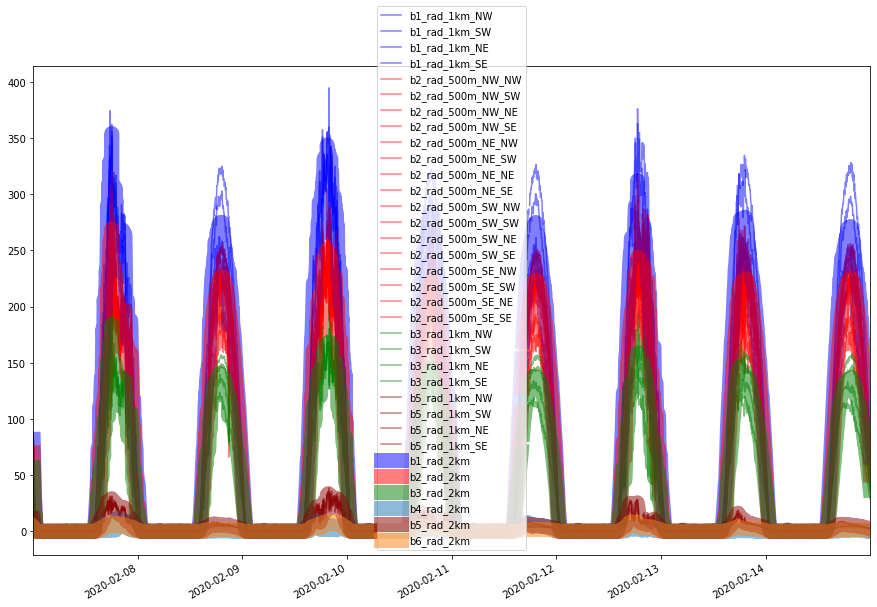

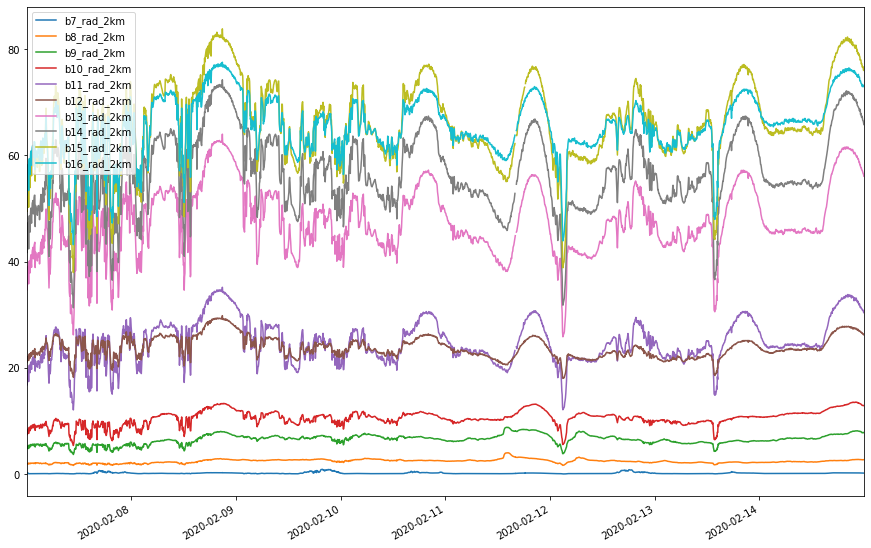

In [128]:
plt.figure(figsize=(15,10))

df.b1_rad_1km_NW.plot(c='b', alpha=0.5)
df.b1_rad_1km_SW.plot(c='b', alpha=0.5)
df.b1_rad_1km_NE.plot(c='b', alpha=0.5)
df.b1_rad_1km_SE.plot(c='b', alpha=0.5)

df.b2_rad_500m_NW_NW.plot(c='r', alpha=0.5)
df.b2_rad_500m_NW_SW.plot(c='r', alpha=0.5)
df.b2_rad_500m_NW_NE.plot(c='r', alpha=0.5)
df.b2_rad_500m_NW_SE.plot(c='r', alpha=0.5)
df.b2_rad_500m_NE_NW.plot(c='r', alpha=0.5)
df.b2_rad_500m_NE_SW.plot(c='r', alpha=0.5)
df.b2_rad_500m_NE_NE.plot(c='r', alpha=0.5)
df.b2_rad_500m_NE_SE.plot(c='r', alpha=0.5)
df.b2_rad_500m_SW_NW.plot(c='r', alpha=0.5)
df.b2_rad_500m_SW_SW.plot(c='r', alpha=0.5)
df.b2_rad_500m_SW_NE.plot(c='r', alpha=0.5)
df.b2_rad_500m_SW_SE.plot(c='r', alpha=0.5)
df.b2_rad_500m_SE_NW.plot(c='r', alpha=0.5)
df.b2_rad_500m_SE_SW.plot(c='r', alpha=0.5)
df.b2_rad_500m_SE_NE.plot(c='r', alpha=0.5)
df.b2_rad_500m_SE_SE.plot(c='r', alpha=0.5)

df.b3_rad_1km_NW.plot(c='g', alpha=0.5)
df.b3_rad_1km_SW.plot(c='g', alpha=0.5)
df.b3_rad_1km_NE.plot(c='g', alpha=0.5)
df.b3_rad_1km_SE.plot(c='g', alpha=0.5)

df.b5_rad_1km_NW.plot(c='darkred', alpha=0.5)
df.b5_rad_1km_SW.plot(c='darkred', alpha=0.5)
df.b5_rad_1km_NE.plot(c='darkred', alpha=0.5)
df.b5_rad_1km_SE.plot(c='darkred', alpha=0.5)


df.b1_rad_2km.plot(c='b', lw=15, alpha=0.5)
df.b2_rad_2km.plot(c='r', lw=15, alpha=0.5)
df.b3_rad_2km.plot(c='g', lw=15, alpha=0.5)
df.b4_rad_2km.plot(lw=15, alpha=0.5)
df.b5_rad_2km.plot(c='darkred', lw=15, alpha=0.5)
df.b6_rad_2km.plot(lw=15, alpha=0.5)


plt.legend()

plt.figure(figsize=(15,10))
df.b7_rad_2km.plot()
df.b8_rad_2km.plot()
df.b9_rad_2km.plot()
df.b10_rad_2km.plot()
df.b11_rad_2km.plot()
df.b12_rad_2km.plot()
df.b13_rad_2km.plot()
df.b14_rad_2km.plot()
df.b15_rad_2km.plot()
df.b16_rad_2km.plot()
plt.legend()

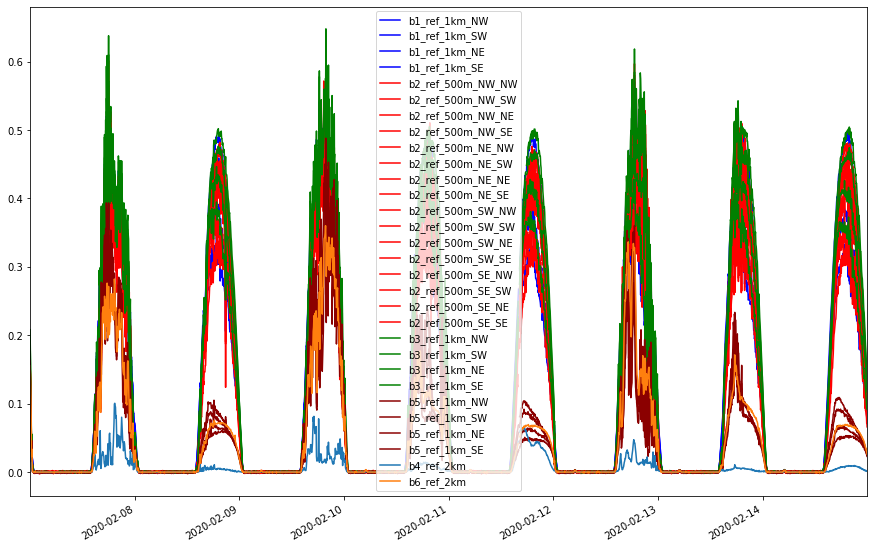

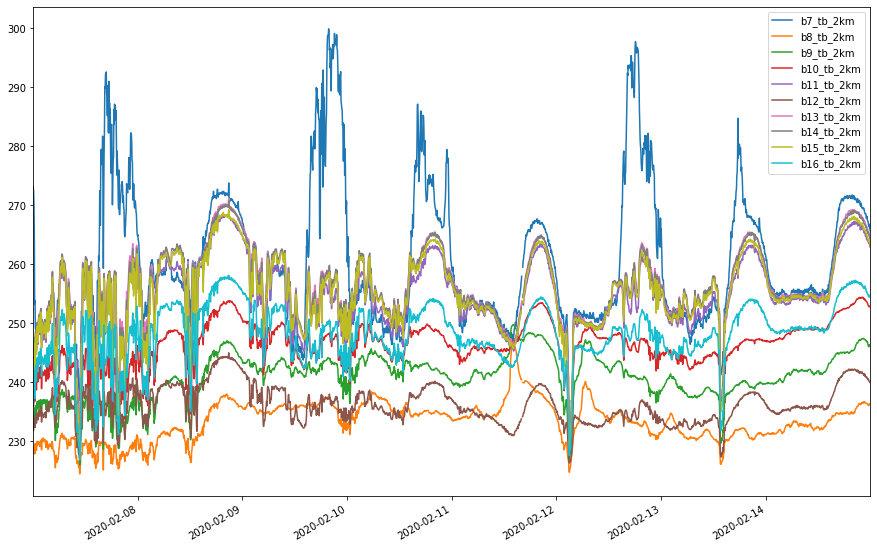

In [129]:
plt.figure(figsize=(15,10))

df.b1_ref_1km_NW.plot(c='b')
df.b1_ref_1km_SW.plot(c='b')
df.b1_ref_1km_NE.plot(c='b')
df.b1_ref_1km_SE.plot(c='b')

df.b2_ref_500m_NW_NW.plot(c='r')
df.b2_ref_500m_NW_SW.plot(c='r')
df.b2_ref_500m_NW_NE.plot(c='r')
df.b2_ref_500m_NW_SE.plot(c='r')
df.b2_ref_500m_NE_NW.plot(c='r')
df.b2_ref_500m_NE_SW.plot(c='r')
df.b2_ref_500m_NE_NE.plot(c='r')
df.b2_ref_500m_NE_SE.plot(c='r')
df.b2_ref_500m_SW_NW.plot(c='r')
df.b2_ref_500m_SW_SW.plot(c='r')
df.b2_ref_500m_SW_NE.plot(c='r')
df.b2_ref_500m_SW_SE.plot(c='r')
df.b2_ref_500m_SE_NW.plot(c='r')
df.b2_ref_500m_SE_SW.plot(c='r')
df.b2_ref_500m_SE_NE.plot(c='r')
df.b2_ref_500m_SE_SE.plot(c='r')

df.b3_ref_1km_NW.plot(c='g')
df.b3_ref_1km_SW.plot(c='g')
df.b3_ref_1km_NE.plot(c='g')
df.b3_ref_1km_SE.plot(c='g')

df.b5_ref_1km_NW.plot(c='darkred')
df.b5_ref_1km_SW.plot(c='darkred')
df.b5_ref_1km_NE.plot(c='darkred')
df.b5_ref_1km_SE.plot(c='darkred')

df.b4_ref_2km.plot()
df.b6_ref_2km.plot()


plt.legend()

plt.figure(figsize=(15,10))
df.b7_tb_2km.plot()
df.b8_tb_2km.plot()
df.b9_tb_2km.plot()
df.b10_tb_2km.plot()
df.b11_tb_2km.plot()
df.b12_tb_2km.plot()
df.b13_tb_2km.plot()
df.b14_tb_2km.plot()
df.b15_tb_2km.plot()
df.b16_tb_2km.plot()
plt.legend()

In [130]:
df.to_csv('GOES-16_ABI_2020_02_07-14_R.csv')

(737466.0, 737468.5)

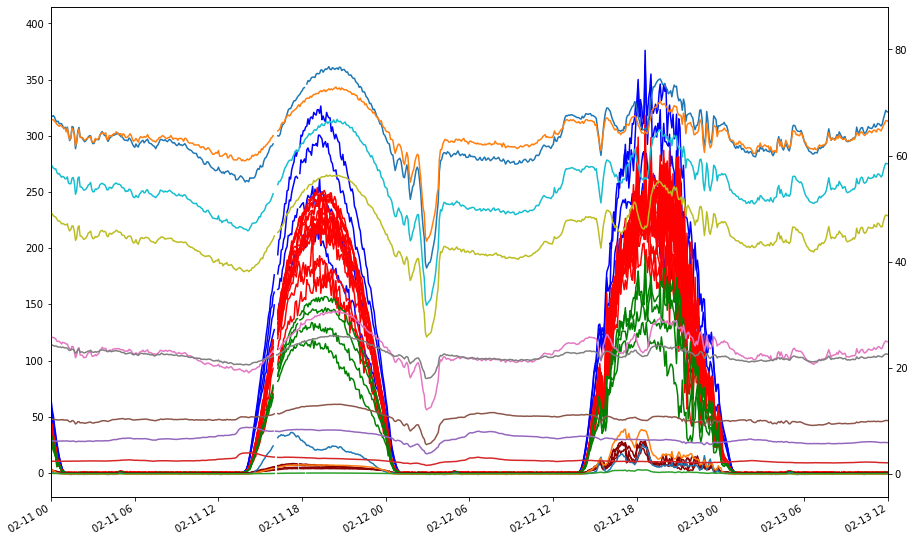

In [132]:
plt.figure(figsize=(15,10))

df.b1_rad_1km_NW.plot(c='b')
df.b1_rad_1km_SW.plot(c='b')
df.b1_rad_1km_NE.plot(c='b')
df.b1_rad_1km_SE.plot(c='b')

df.b2_rad_500m_NW_NW.plot(c='r')
df.b2_rad_500m_NW_SW.plot(c='r')
df.b2_rad_500m_NW_NE.plot(c='r')
df.b2_rad_500m_NW_SE.plot(c='r')
df.b2_rad_500m_NE_NW.plot(c='r')
df.b2_rad_500m_NE_SW.plot(c='r')
df.b2_rad_500m_NE_NE.plot(c='r')
df.b2_rad_500m_NE_SE.plot(c='r')
df.b2_rad_500m_SW_NW.plot(c='r')
df.b2_rad_500m_SW_SW.plot(c='r')
df.b2_rad_500m_SW_NE.plot(c='r')
df.b2_rad_500m_SW_SE.plot(c='r')
df.b2_rad_500m_SE_NW.plot(c='r')
df.b2_rad_500m_SE_SW.plot(c='r')
df.b2_rad_500m_SE_NE.plot(c='r')
df.b2_rad_500m_SE_SE.plot(c='r')

df.b3_rad_1km_NW.plot(c='g')
df.b3_rad_1km_SW.plot(c='g')
df.b3_rad_1km_NE.plot(c='g')
df.b3_rad_1km_SE.plot(c='g')

df.b5_rad_1km_NW.plot(c='darkred')
df.b5_rad_1km_SW.plot(c='darkred')
df.b5_rad_1km_NE.plot(c='darkred')
df.b5_rad_1km_SE.plot(c='darkred')

ax2 = plt.gca().twinx()
df.b4_rad_2km.plot(ax=ax2)
df.b6_rad_2km.plot(ax=ax2)
df.b7_rad_2km.plot(ax=ax2)
df.b8_rad_2km.plot(ax=ax2)
df.b9_rad_2km.plot(ax=ax2)
df.b10_rad_2km.plot(ax=ax2)
df.b11_rad_2km.plot(ax=ax2)
df.b12_rad_2km.plot(ax=ax2)
df.b13_rad_2km.plot(ax=ax2)
df.b14_rad_2km.plot(ax=ax2)
df.b15_rad_2km.plot(ax=ax2)
df.b16_rad_2km.plot(ax=ax2)

plt.xlim(pd.Timestamp('2020-02-11'),pd.Timestamp('2020-02-13 12'))

(737466.0, 737467.5)

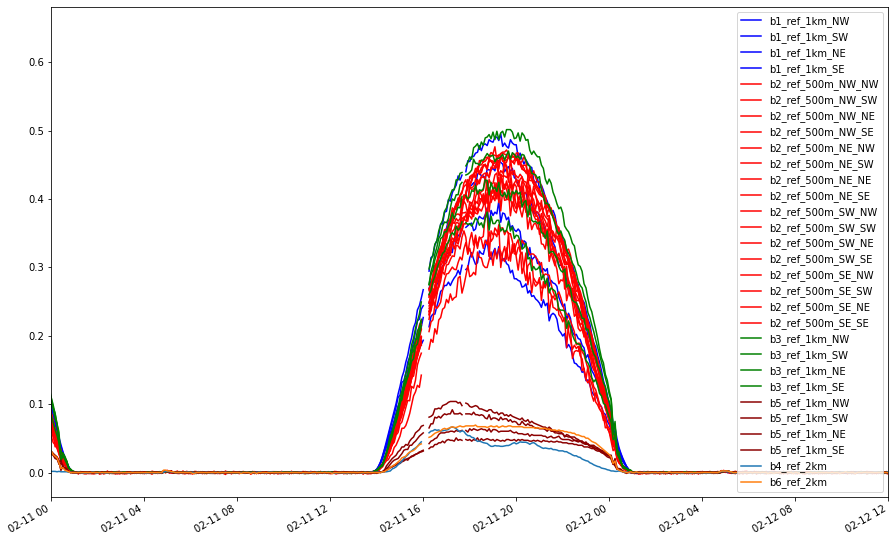

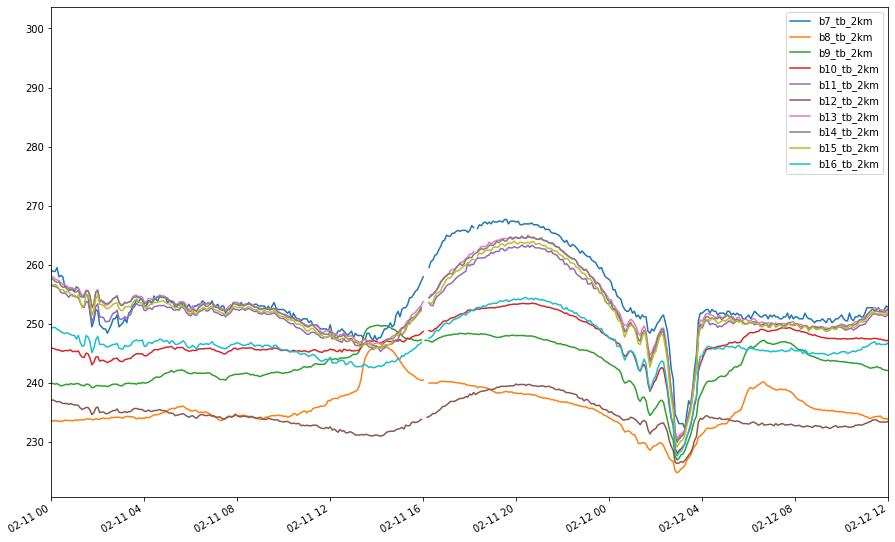

In [136]:
plt.figure(figsize=(15,10))

df.b1_ref_1km_NW.plot(c='b')
df.b1_ref_1km_SW.plot(c='b')
df.b1_ref_1km_NE.plot(c='b')
df.b1_ref_1km_SE.plot(c='b')

df.b2_ref_500m_NW_NW.plot(c='r')
df.b2_ref_500m_NW_SW.plot(c='r')
df.b2_ref_500m_NW_NE.plot(c='r')
df.b2_ref_500m_NW_SE.plot(c='r')
df.b2_ref_500m_NE_NW.plot(c='r')
df.b2_ref_500m_NE_SW.plot(c='r')
df.b2_ref_500m_NE_NE.plot(c='r')
df.b2_ref_500m_NE_SE.plot(c='r')
df.b2_ref_500m_SW_NW.plot(c='r')
df.b2_ref_500m_SW_SW.plot(c='r')
df.b2_ref_500m_SW_NE.plot(c='r')
df.b2_ref_500m_SW_SE.plot(c='r')
df.b2_ref_500m_SE_NW.plot(c='r')
df.b2_ref_500m_SE_SW.plot(c='r')
df.b2_ref_500m_SE_NE.plot(c='r')
df.b2_ref_500m_SE_SE.plot(c='r')

df.b3_ref_1km_NW.plot(c='g')
df.b3_ref_1km_SW.plot(c='g')
df.b3_ref_1km_NE.plot(c='g')
df.b3_ref_1km_SE.plot(c='g')

df.b5_ref_1km_NW.plot(c='darkred')
df.b5_ref_1km_SW.plot(c='darkred')
df.b5_ref_1km_NE.plot(c='darkred')
df.b5_ref_1km_SE.plot(c='darkred')

df.b4_ref_2km.plot()
df.b6_ref_2km.plot()


plt.legend(loc='center right')
plt.xlim(pd.Timestamp('2020-02-11'),pd.Timestamp('2020-02-12 12'))

plt.figure(figsize=(15,10))
df.b7_tb_2km.plot()
df.b8_tb_2km.plot()
df.b9_tb_2km.plot()
df.b10_tb_2km.plot()
df.b11_tb_2km.plot()
df.b12_tb_2km.plot()
df.b13_tb_2km.plot()
df.b14_tb_2km.plot()
df.b15_tb_2km.plot()
df.b16_tb_2km.plot()
plt.legend()
plt.xlim(pd.Timestamp('2020-02-11'),pd.Timestamp('2020-02-12 12'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

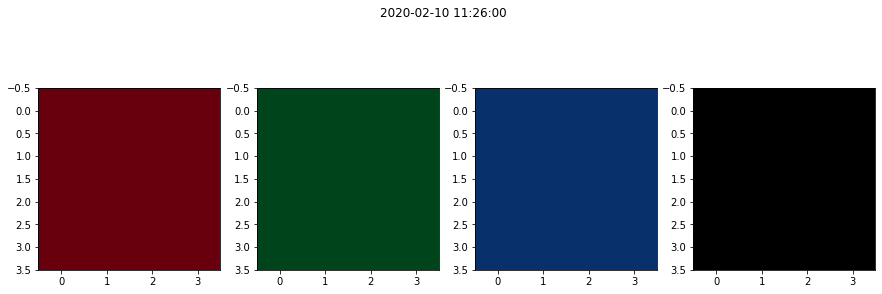

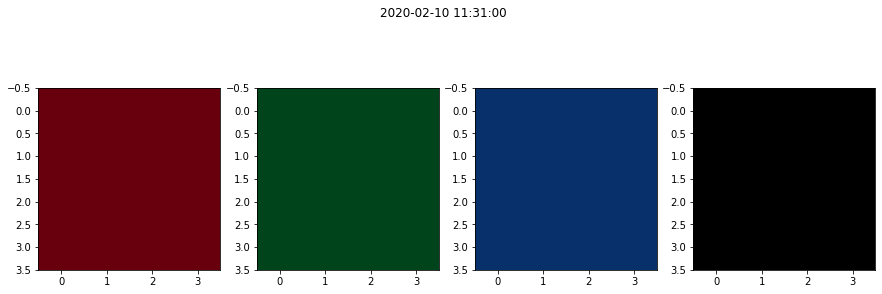

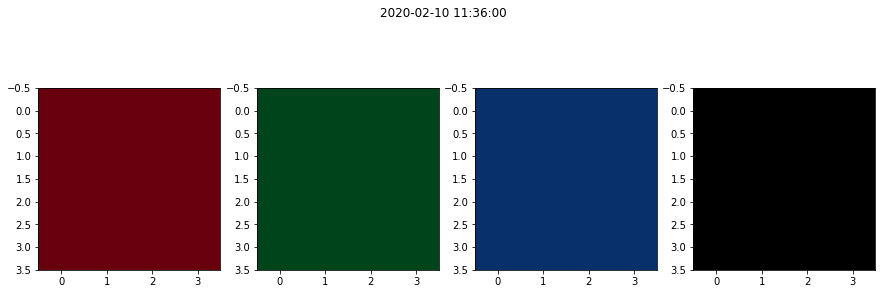

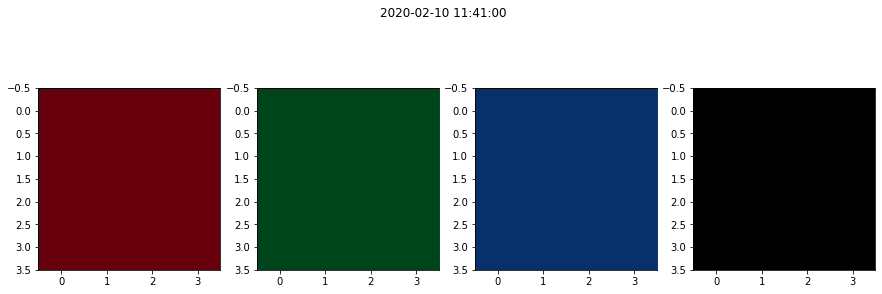

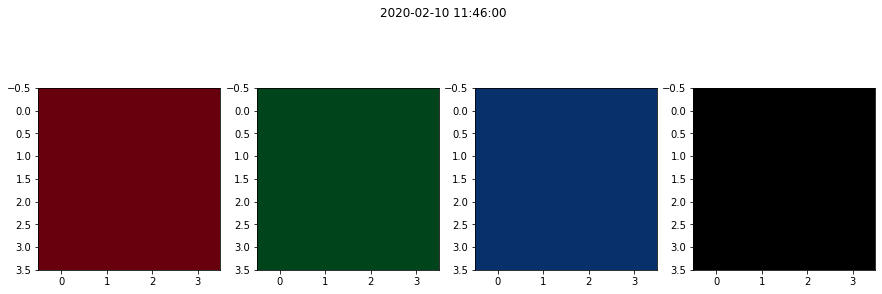

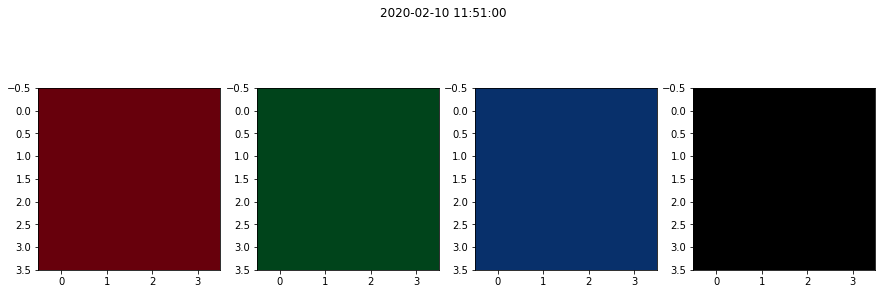

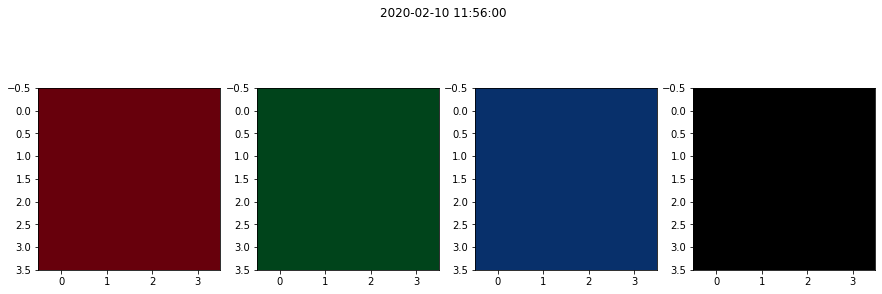

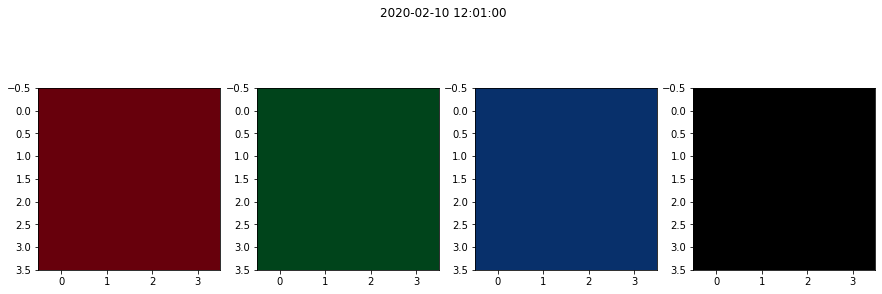

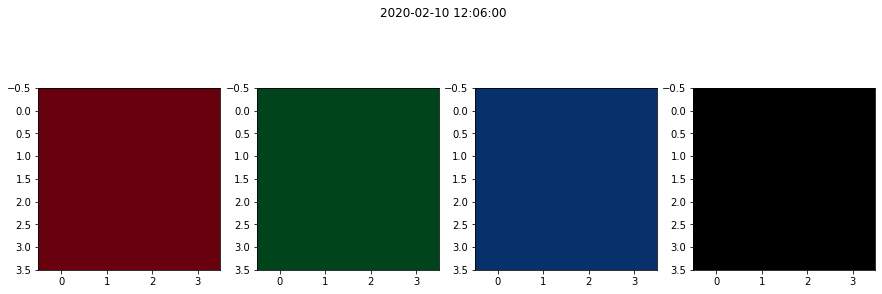

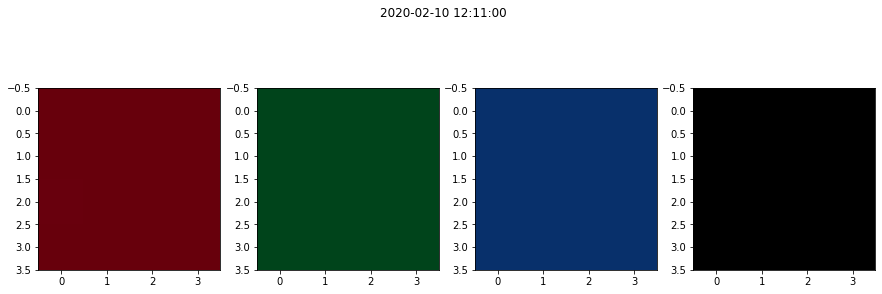

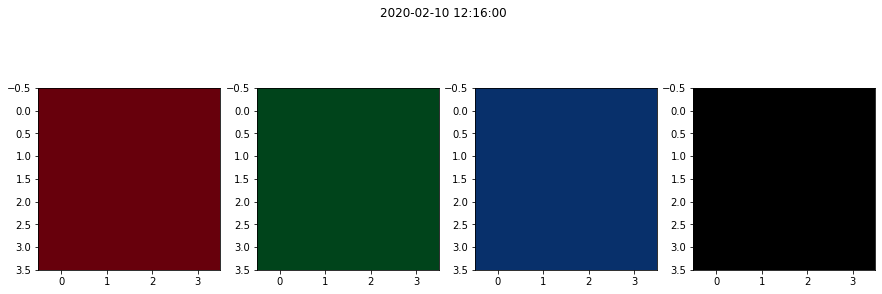

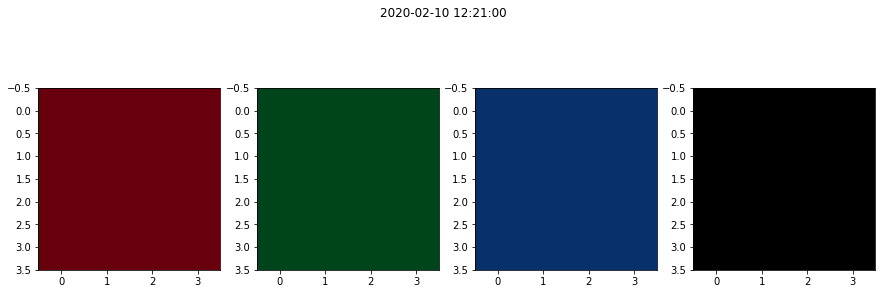

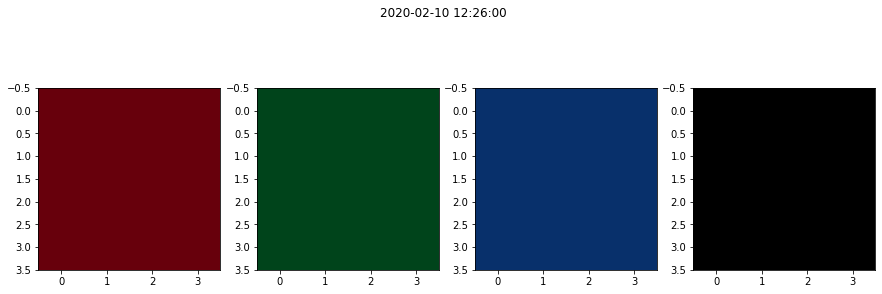

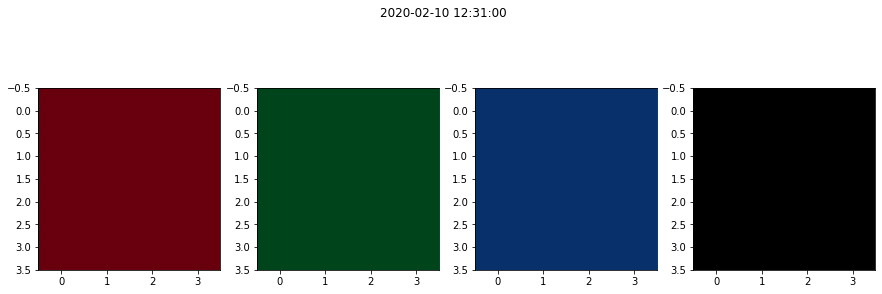

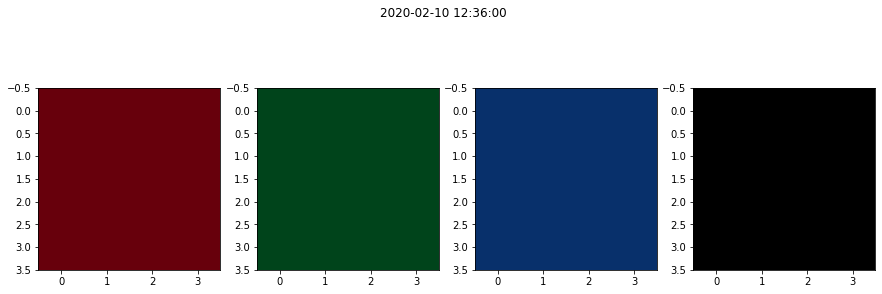

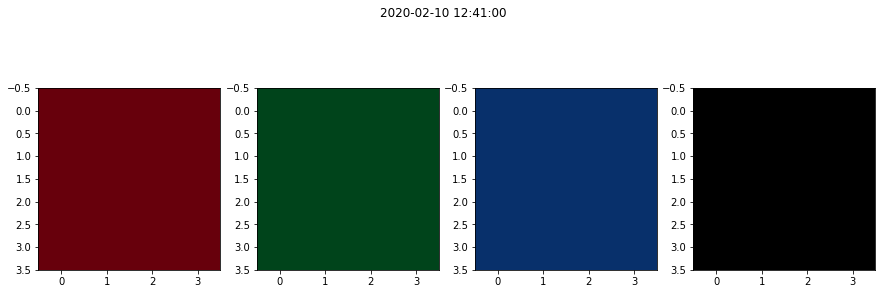

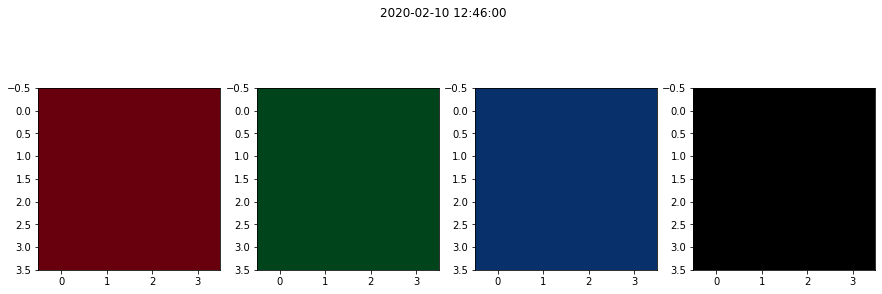

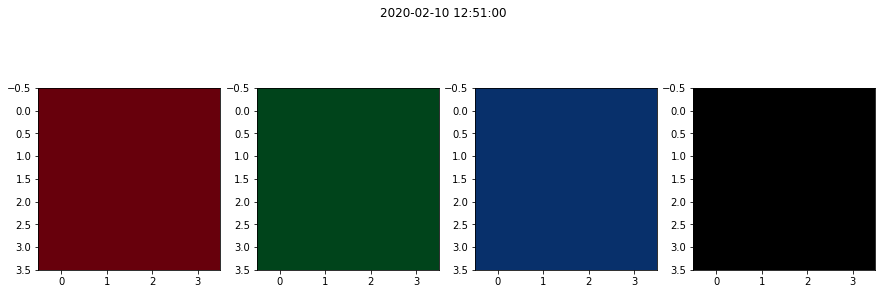

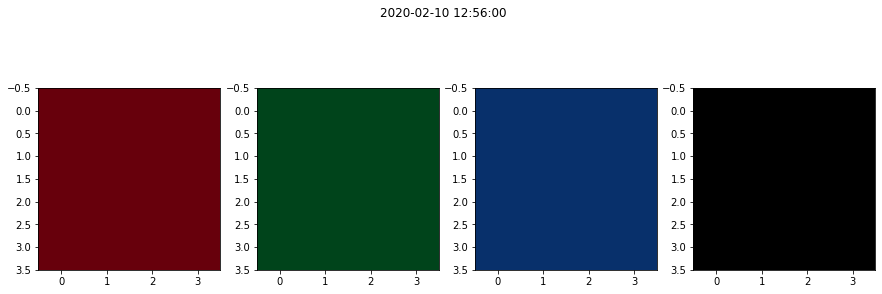

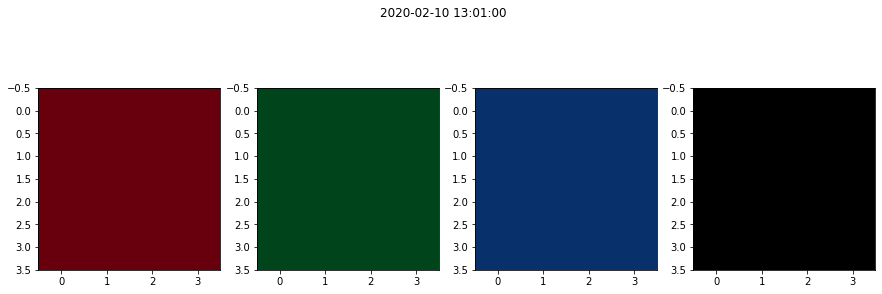

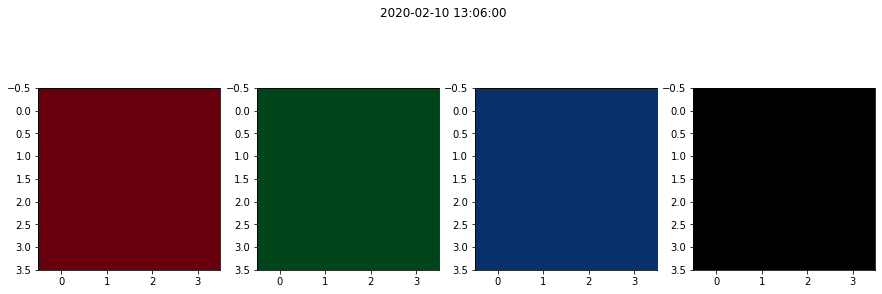

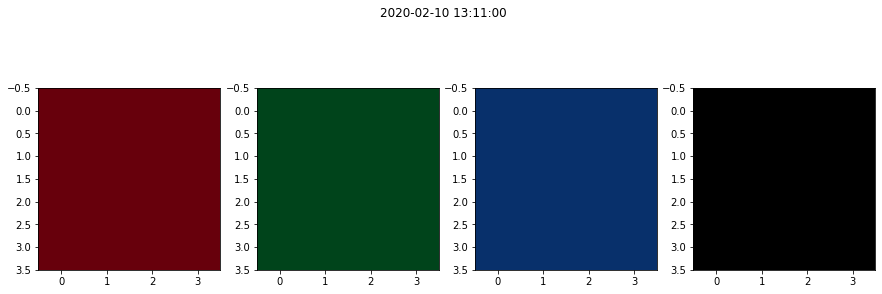

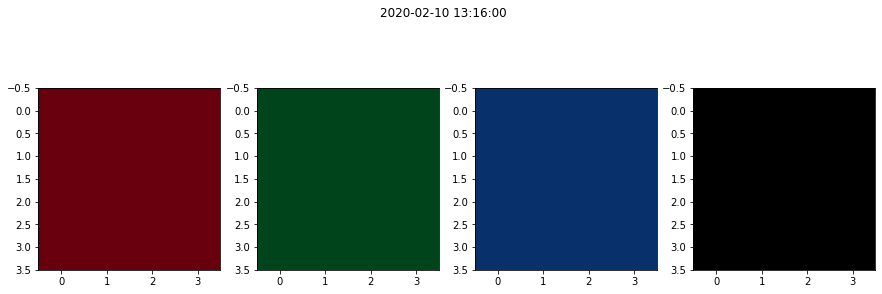

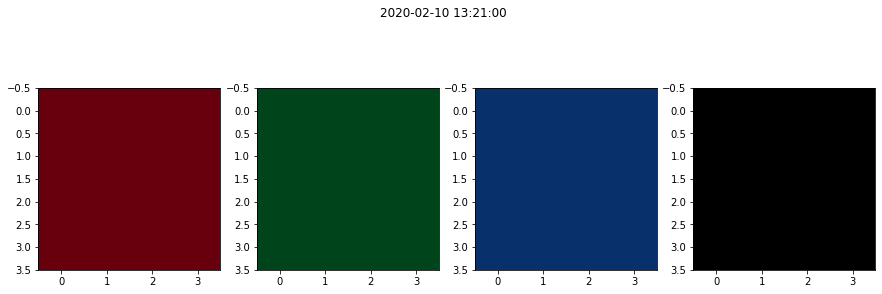

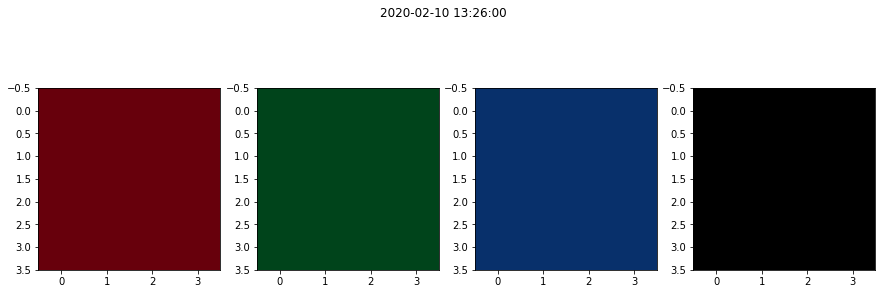

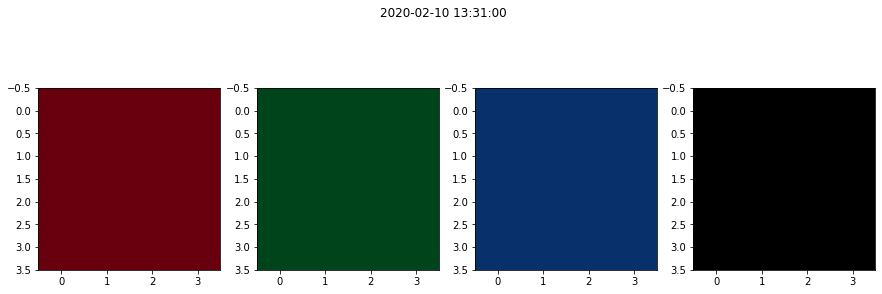

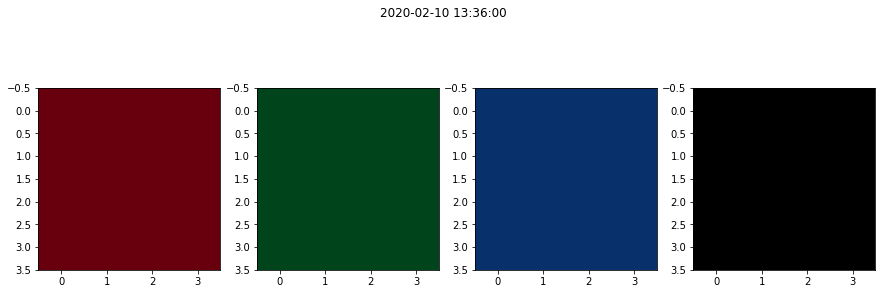

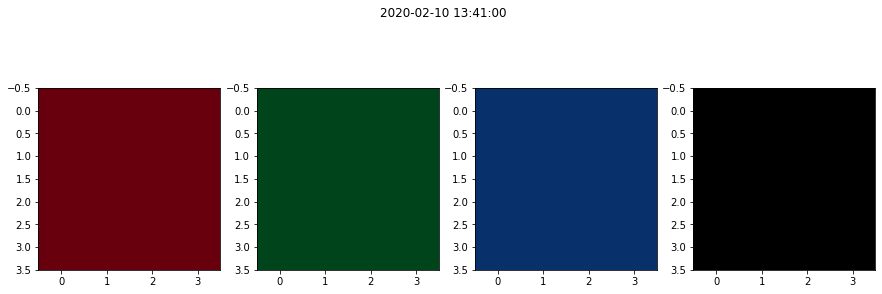

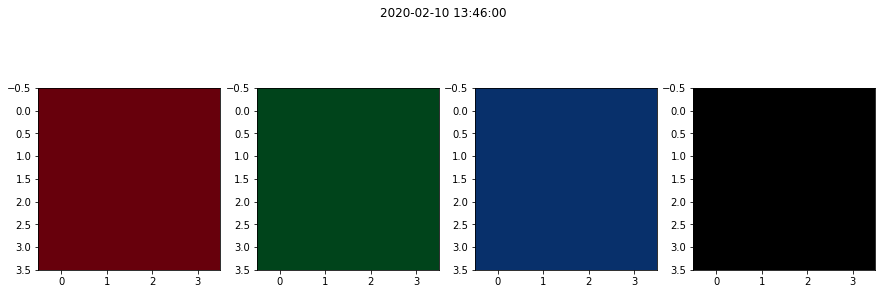

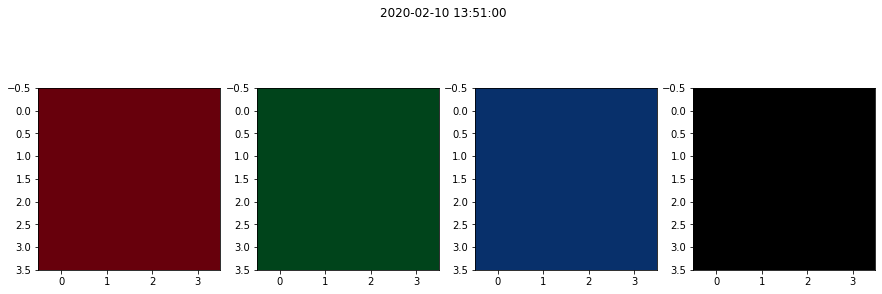

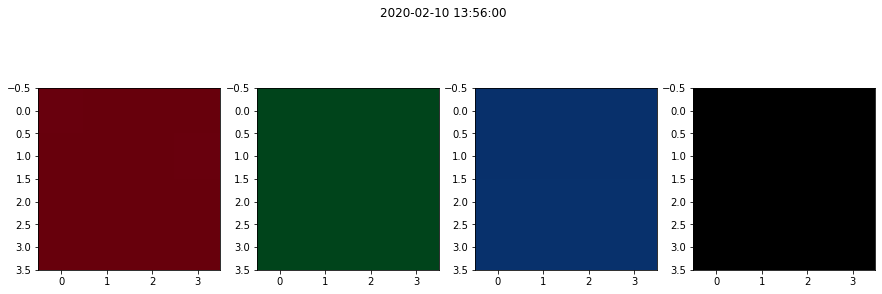

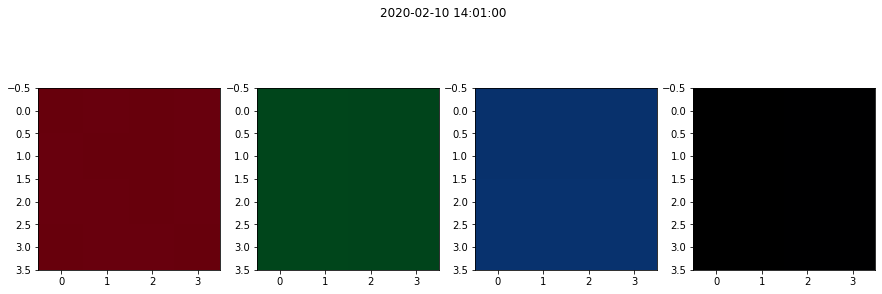

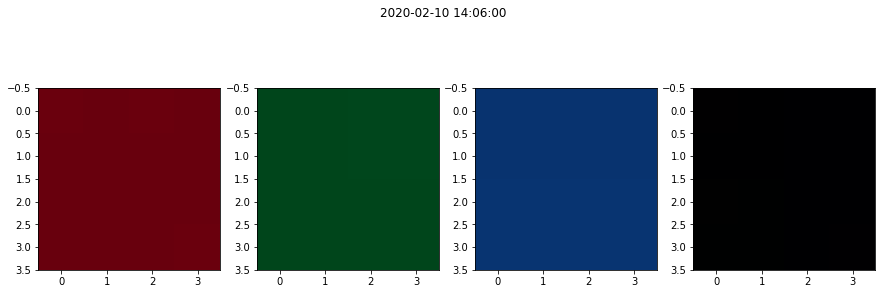

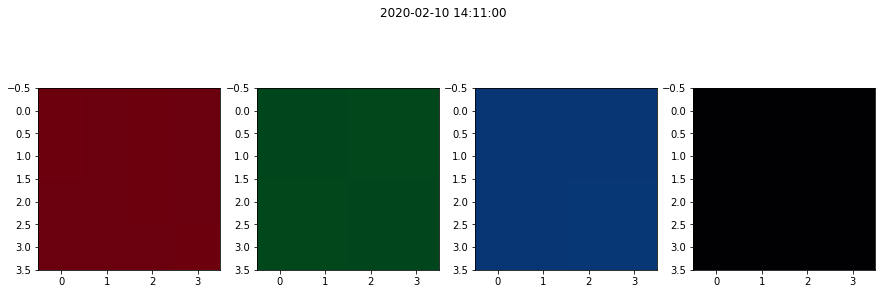

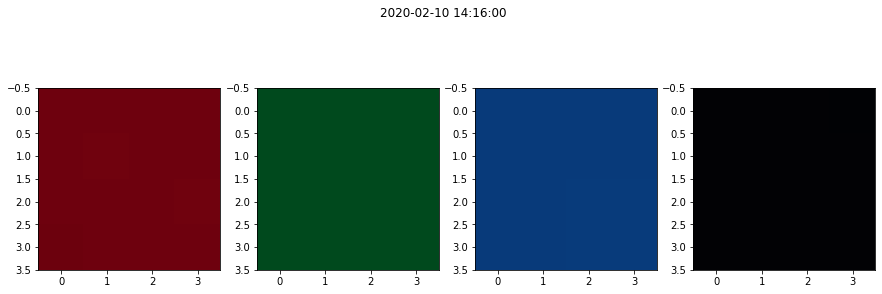

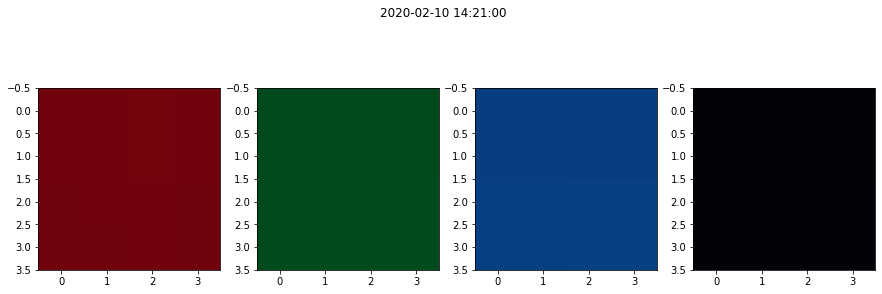

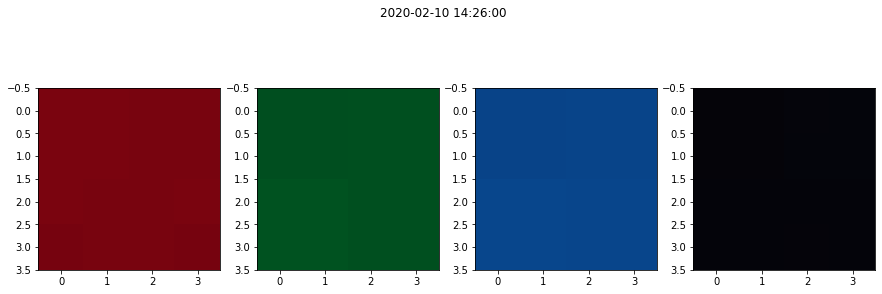

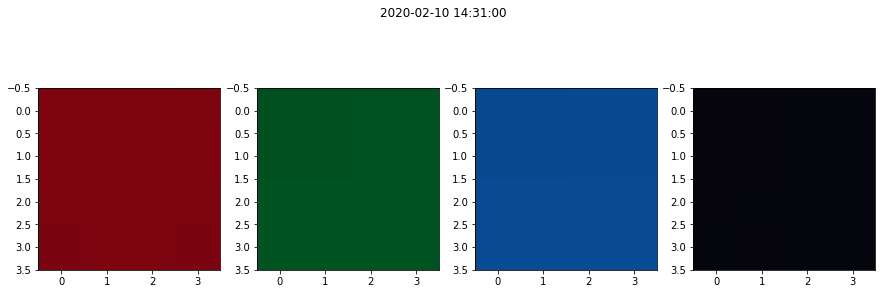

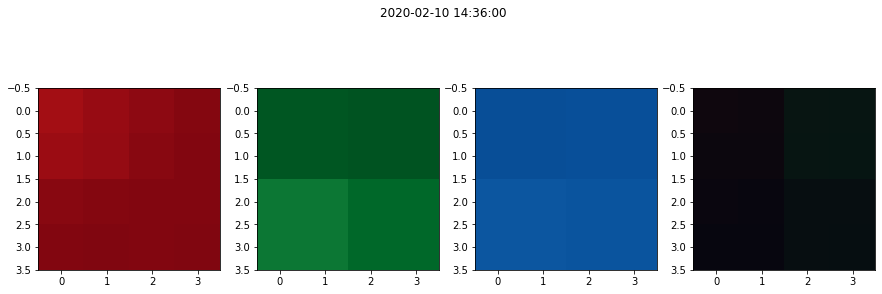

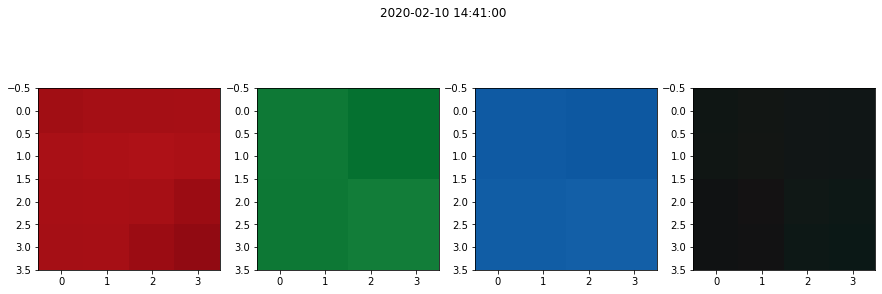

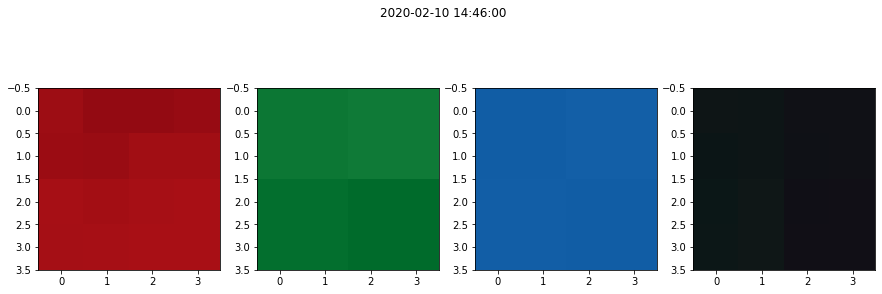

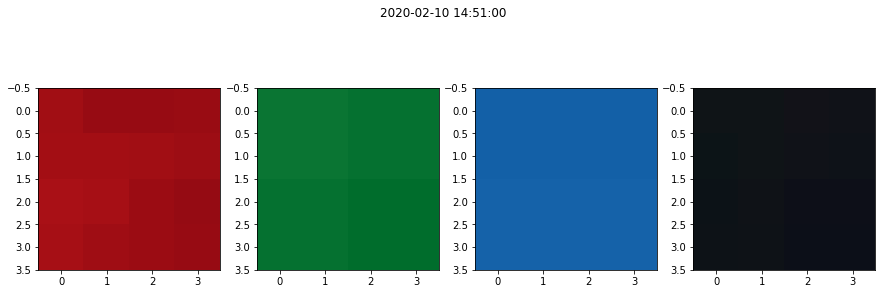

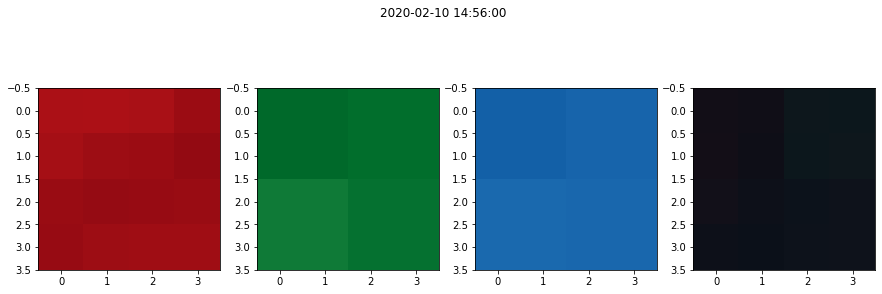

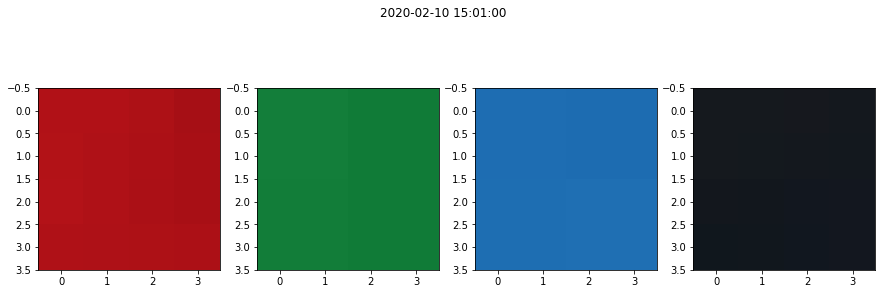

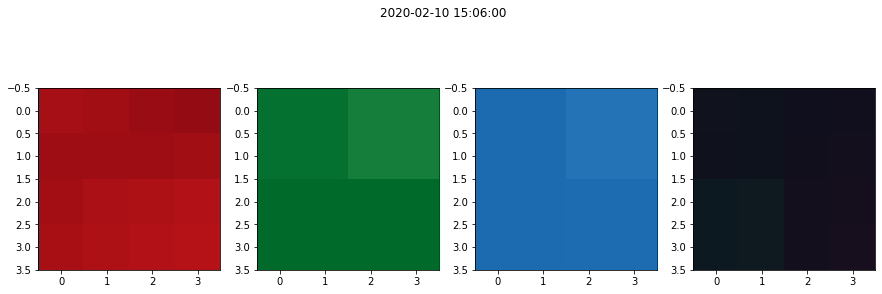

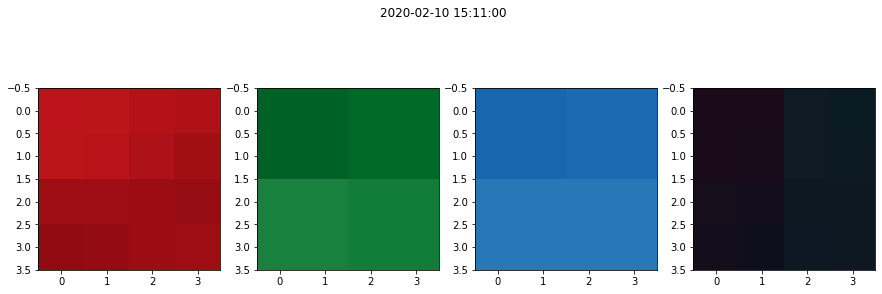

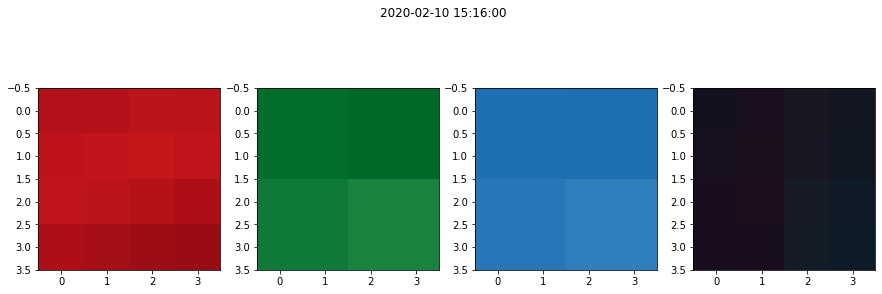

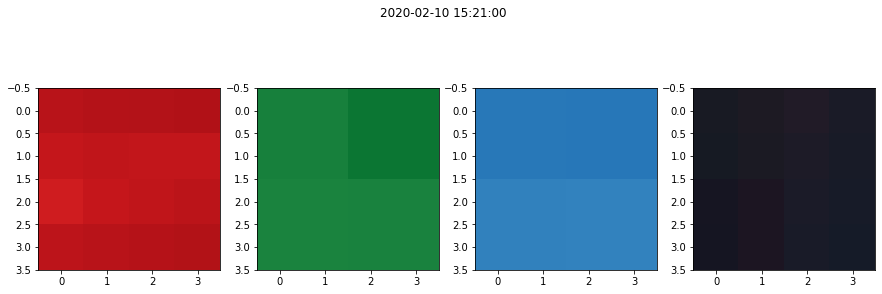

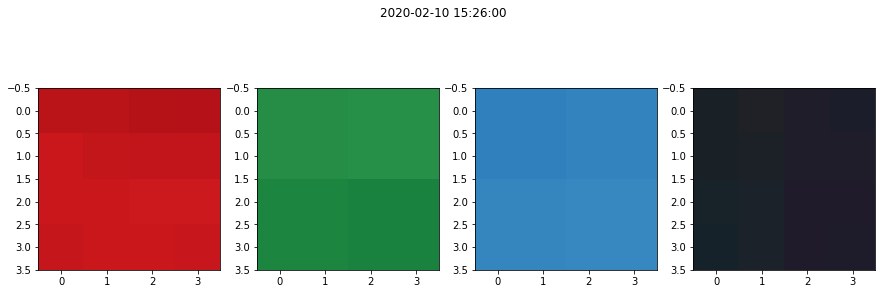

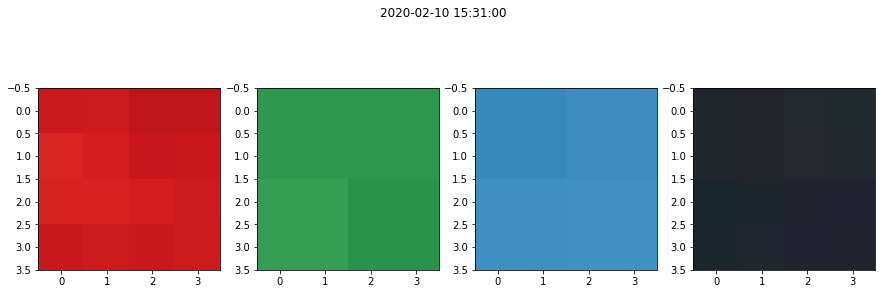

In [146]:
x=0
for idx, row in df.iterrows():
    if x>1000 and x<=1050:
        b2_array = np.array([row.b2_ref_500m_NW_NW, row.b2_ref_500m_NW_NE, row.b2_ref_500m_NE_NW, row.b2_ref_500m_NE_NE, 
                             row.b2_ref_500m_NW_SW, row.b2_ref_500m_NW_SE, row.b2_ref_500m_NE_SW, row.b2_ref_500m_NE_SE, 
                             row.b2_ref_500m_SW_NW, row.b2_ref_500m_SW_NE, row.b2_ref_500m_SE_NW, row.b2_ref_500m_SE_NE, 
                             row.b2_ref_500m_SW_SW, row.b2_ref_500m_SW_SE, row.b2_ref_500m_SE_SW, row.b2_ref_500m_SE_SE])
        b2_array = b2_array.reshape(4,4)
        b1_array = np.array([row.b1_ref_1km_NW, row.b1_ref_1km_NE, 
                             row.b1_ref_1km_SW, row.b1_ref_1km_SE]).reshape(2,2)
        b1_array = np.repeat(np.repeat(b1_array, 2, axis=0), 2, axis=1)
        b3_array = np.array([row.b3_ref_1km_NW, row.b3_ref_1km_NE, 
                             row.b3_ref_1km_SW, row.b3_ref_1km_SE]).reshape(2,2)
        b3_array = np.repeat(np.repeat(b3_array, 2, axis=0), 2, axis=1)
        RGB_array = np.array([b2_array, b3_array, b1_array]).T
        f, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1,ncols=4,figsize=(15,5))
        ax1.imshow(b2_array, vmin=0, vmax=0.5, cmap='Reds_r')
        ax2.imshow(b3_array, vmin=0, vmax=0.5, cmap='Greens_r')
        ax3.imshow(b1_array, vmin=0, vmax=0.5, cmap='Blues_r')
        ax4.imshow(RGB_array, vmin=0, vmax=0.5)
        plt.suptitle(idx)
    x+=1

In [56]:
!ls /storage/GOES/goes16/2019/10/11/ABI-L1b-RadC/17/C02/

OR_ABI-L1b-RadC-M6C02_G16_s20192841701271_e20192841704044_c20192841704098.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841706271_e20192841709044_c20192841709084.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841711271_e20192841714044_c20192841714096.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841716271_e20192841719044_c20192841719086.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841721271_e20192841724044_c20192841724099.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841726271_e20192841729044_c20192841729086.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841731271_e20192841734044_c20192841734095.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841736271_e20192841739044_c20192841739087.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841741271_e20192841744044_c20192841744108.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841746271_e20192841749044_c20192841749087.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841751271_e20192841754044_c20192841754099.nc
OR_ABI-L1b-RadC-M6C02_G16_s20192841756271_e20192841759044_c20192841759094.nc


In [57]:
ds1 = xr.open_dataset('/storage/GOES/goes16/2019/10/11/ABI-L1b-RadC/16/C02/OR_ABI-L1b-RadC-M6C02_G16_s20192841601271_e20192841604044_c20192841604093.nc')
ds2 = xr.open_dataset('/storage/GOES/goes16/2019/10/11/ABI-L1b-RadC/16/C02/OR_ABI-L1b-RadC-M6C02_G16_s20192841631271_e20192841634044_c20192841634100.nc')
ds3 = xr.open_dataset('/storage/GOES/goes16/2019/10/11/ABI-L1b-RadC/17/C02/OR_ABI-L1b-RadC-M6C02_G16_s20192841756271_e20192841759044_c20192841759094.nc')

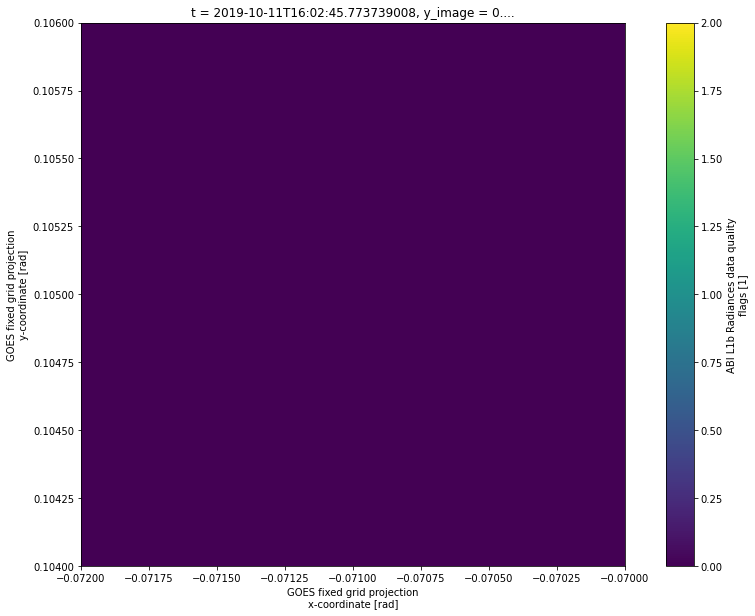

In [58]:
plt.figure(figsize=(15,10))
ds1.DQF.plot()
plt.xlim(-0.072, -0.070)
plt.ylim(0.104, 0.106)
plt.gca().set_aspect(1)

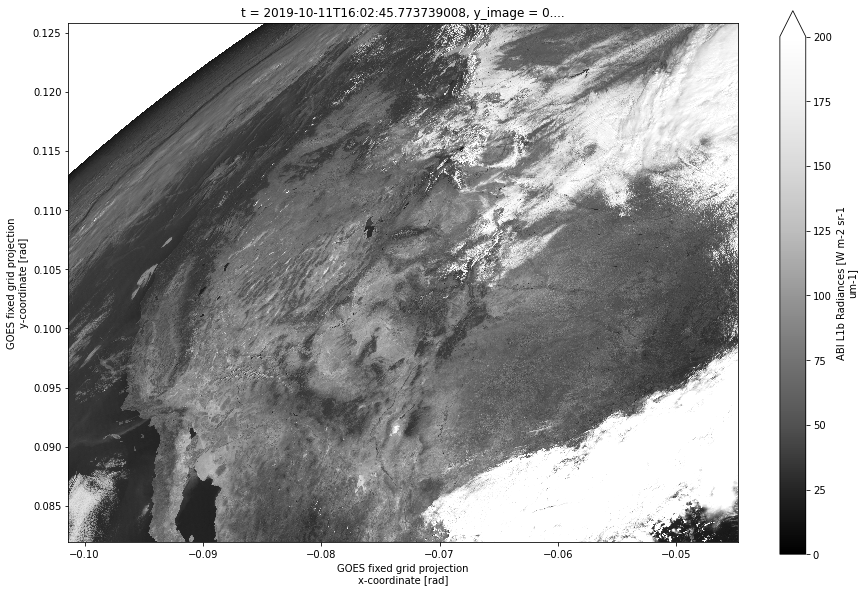

In [59]:
plt.figure(figsize=(15,10))
ds1.Rad.plot(vmin=0, vmax=200, cmap='Greys_r')
#plt.xlim(-0.072, -0.070)
#plt.ylim(0.104, 0.106)
plt.gca().set_aspect(1)

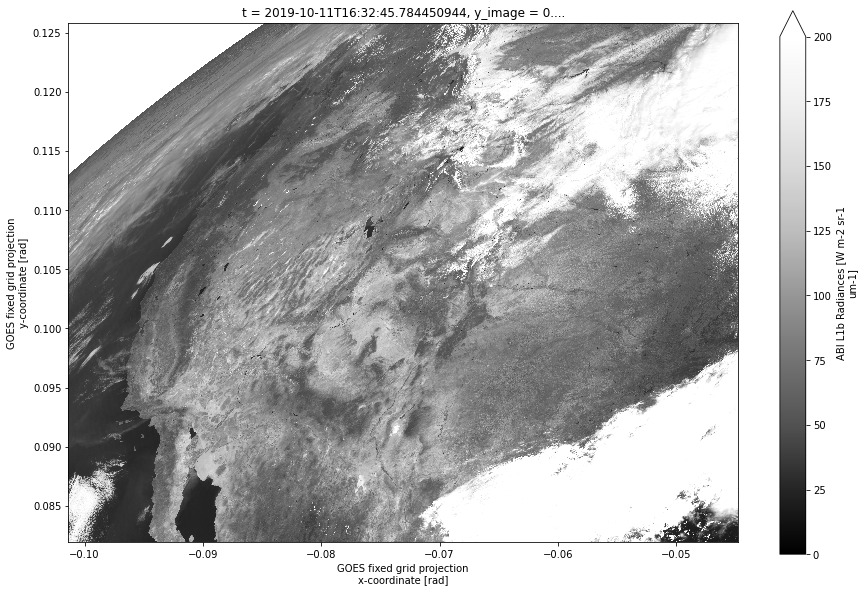

In [60]:
plt.figure(figsize=(15,10))
ds2.Rad.plot(vmin=0, vmax=200, cmap='Greys_r')
#plt.xlim(-0.072, -0.070)
#plt.ylim(0.104, 0.106)
plt.gca().set_aspect(1)

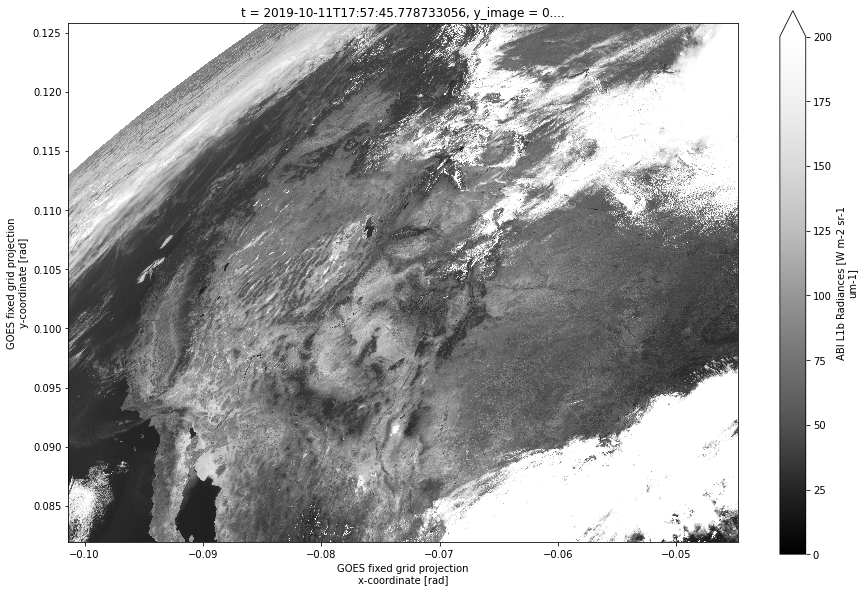

In [61]:
plt.figure(figsize=(15,10))
ds3.Rad.plot(vmin=0, vmax=200, cmap='Greys_r')
#plt.xlim(-0.072, -0.070)
#plt.ylim(0.104, 0.106)
plt.gca().set_aspect(1)

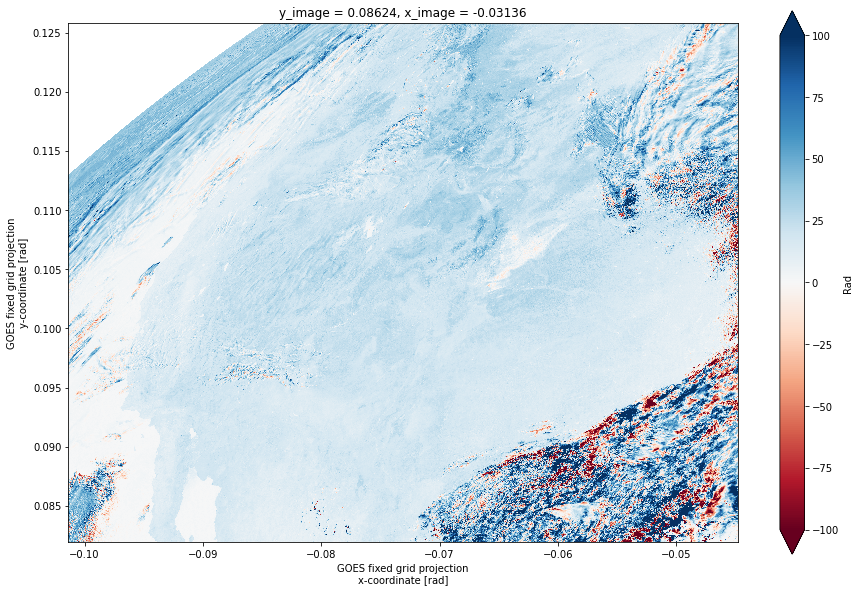

In [66]:
plt.figure(figsize=(15,10))
(ds2.Rad-ds1.Rad).plot(vmin=-100, vmax=100, cmap='RdBu')
#plt.xlim(-0.072, -0.070)
#plt.ylim(0.104, 0.106)
plt.gca().set_aspect(1)

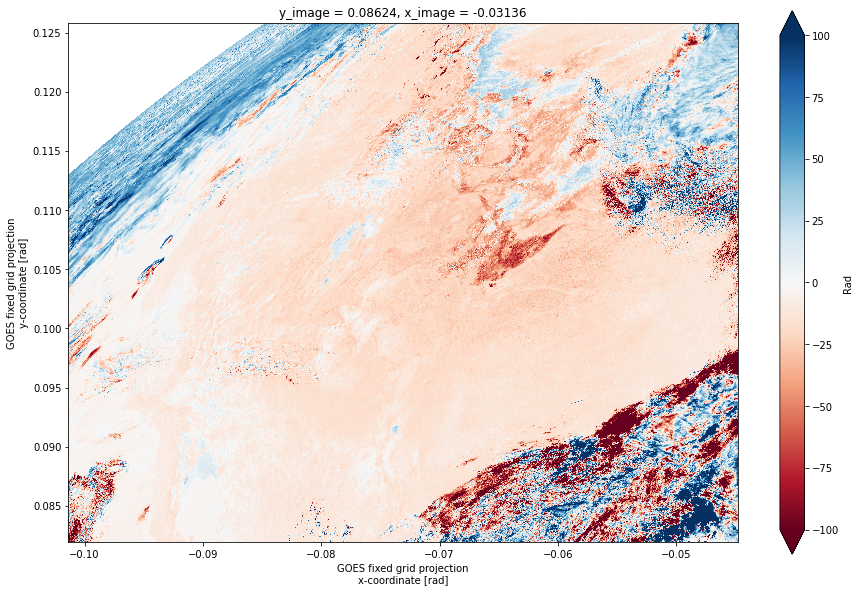

In [67]:
plt.figure(figsize=(15,10))
(ds3.Rad-ds2.Rad).plot(vmin=-100, vmax=100, cmap='RdBuq')
#plt.xlim(-0.072, -0.070)
#plt.ylim(0.104, 0.106)
plt.gca().set_aspect(1)

In [25]:
merged_ds = xr.merge(data_list)

In [44]:
merged_df = merged_ds.to_dataframe()

In [49]:
merged_df

y_image  x_image  rad  ref  tb
band t                   x         y                                       
1    2020-02-08 00:01:00 -0.071001 0.104727  0.08624 -0.03136  NaN  NaN NaN
                                   0.104734  0.08624 -0.03136  NaN  NaN NaN
                                   0.104741  0.08624 -0.03136  NaN  NaN NaN
                                   0.104748  0.08624 -0.03136  NaN  NaN NaN
                                   0.104755  0.08624 -0.03136  NaN  NaN NaN
...                                              ...      ...  ...  ...  ..
16   2020-02-08 00:56:00 -0.070959 0.104741  0.08624 -0.03136  NaN  NaN NaN
                                   0.104748  0.08624 -0.03136  NaN  NaN NaN
                                   0.104755  0.08624 -0.03136  NaN  NaN NaN
                                   0.104762  0.08624 -0.03136  NaN  NaN NaN
                                   0.104769  0.08624 -0.03136  NaN  NaN NaN

[9408 rows x 5 columns]

In [57]:
merged_df.unstack(level=0)

y_image                             \
band                                         1        2        3        4    
t                   x         y                                              
2020-02-08 00:01:00 -0.071001 0.104727  0.08624  0.08624  0.08624  0.08624   
                              0.104734  0.08624  0.08624  0.08624  0.08624   
                              0.104741  0.08624  0.08624  0.08624  0.08624   
                              0.104748  0.08624  0.08624  0.08624  0.08624   
                              0.104755  0.08624  0.08624  0.08624  0.08624   
...                                         ...      ...      ...      ...   
2020-02-08 00:56:00 -0.070959 0.104741  0.08624  0.08624  0.08624  0.08624   
                              0.104748  0.08624  0.08624  0.08624  0.08624   
                              0.104755  0.08624  0.08624  0.08624  0.08624   
                              0.104762  0.08624  0.08624  0.08624  0.08624   
                              0.104769  0.08624  0.08624  0.08624  0.08624   

                                                                            \
band                                         5        6        7        8    
t                   x         y                                              
2020-02-08 00:01:00 -0.071001 0.104727  0.08624  0.08624  0.08624  0.08624   
                              0.104734  0.08624  0.08624  0.08624  0.08624   
                              0.104741  0.08624  0.08624  0.08624  0.08624   
                              0.104748  0.08624  0.08624  0.08624  0.08624   
                              0.104755  0.08624  0.08624  0.08624  0.08624   
...                                         ...      ...      ...      ...   
2020-02-08 00:56:00 -0.070959 0.104741  0.08624  0.08624  0.08624  0.08624   
                              0.104748  0.08624  0.08624  0.08624  0.08624   
                              0.104755  0.08624  0.08624  0.08624  0.08624   
                              0.104762  0.08624  0.08624  0.08624  0.08624   
                              0.104769  0.08624  0.08624  0.08624  0.08624   

                                                          ...  tb              \
band                                         9        10  ...  7   8   9   10   
t                   x         y                           ...                   
2020-02-08 00:01:00 -0.071001 0.104727  0.08624  0.08624  ... NaN NaN NaN NaN   
                              0.104734  0.08624  0.08624  ... NaN NaN NaN NaN   
                              0.104741  0.08624  0.08624  ... NaN NaN NaN NaN   
                              0.104748  0.08624  0.08624  ... NaN NaN NaN NaN   
                              0.104755  0.08624  0.08624  ... NaN NaN NaN NaN   
...                                         ...      ...  ...  ..  ..  ..  ..   
2020-02-08 00:56:00 -0.070959 0.104741  0.08624  0.08624  ... NaN NaN NaN NaN   
                              0.104748  0.08624  0.08624  ... NaN NaN NaN NaN   
                              0.104755  0.08624  0.08624  ... NaN NaN NaN NaN   
                              0.104762  0.08624  0.08624  ... NaN NaN NaN NaN   
                              0.104769  0.08624  0.08624  ... NaN NaN NaN NaN   

                                                                
band                                    11  12  13  14  15  16  
t                   x         y                                 
2020-02-08 00:01:00 -0.071001 0.104727 NaN NaN NaN NaN NaN NaN  
                              0.104734 NaN NaN NaN NaN NaN NaN  
                              0.104741 NaN NaN NaN NaN NaN NaN  
                              0.104748 NaN NaN NaN NaN NaN NaN  
                              0.104755 NaN NaN NaN NaN NaN NaN  
...                                     ..  ..  ..  ..  ..  ..  
2020-02-08 00:56:00 -0.070959 0.104741 NaN NaN NaN NaN NaN NaN  
                              0.104748 NaN NaN NaN NaN NaN NaN  
    

In [6]:
merged_ds.to_netcdf('test_merged.nc')

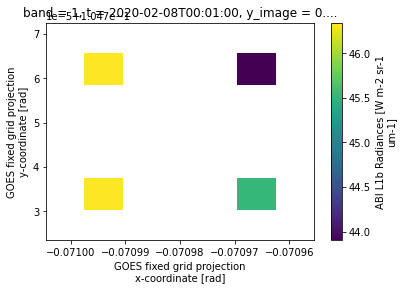

In [13]:
merged_ds.rad.sel(band=1).isel(t=0).plot()

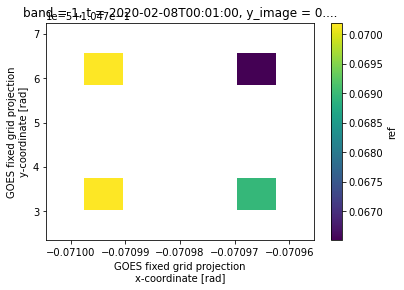

In [8]:
merged_ds.sel(band=1).isel(t=0).ref.plot()

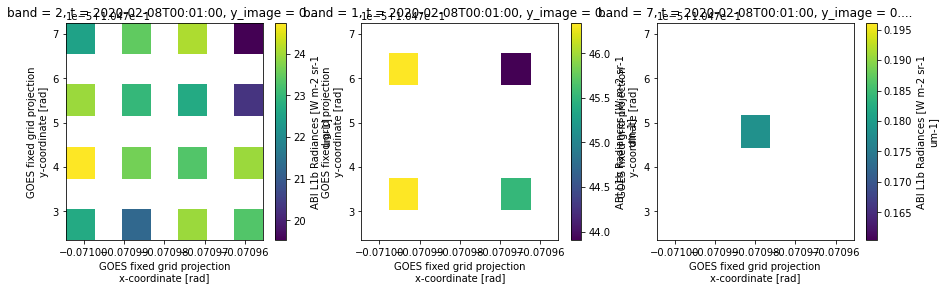

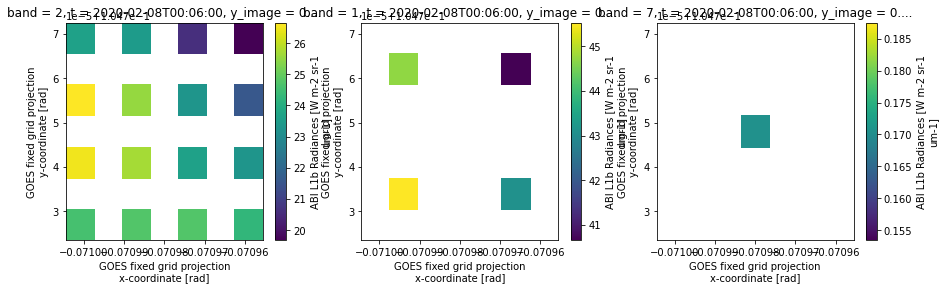

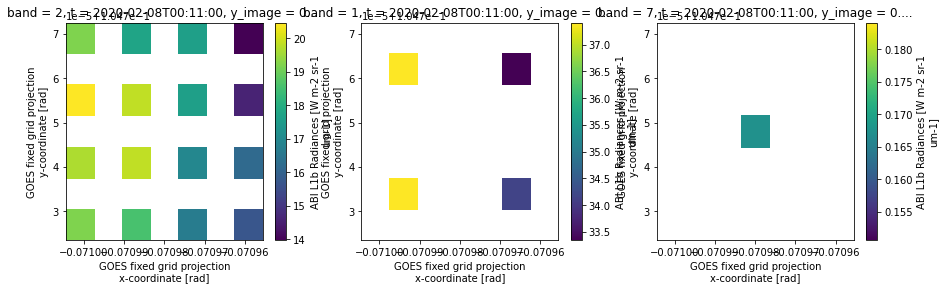

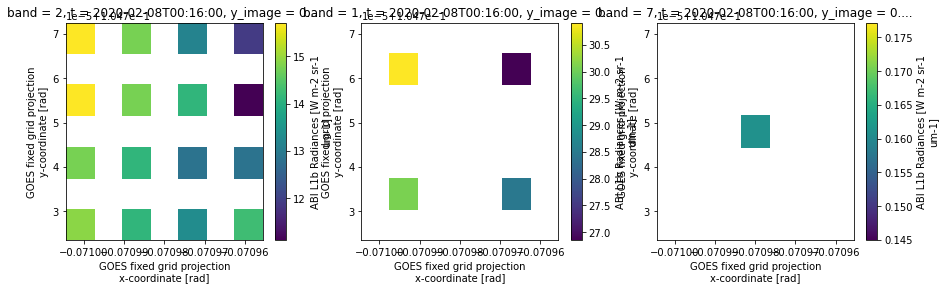

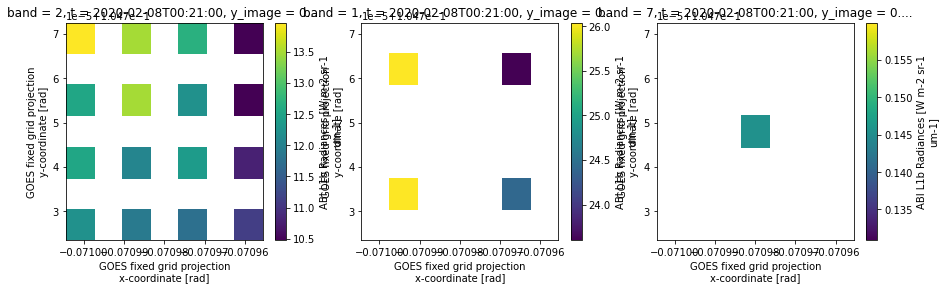

In [14]:
for i in range(5):
    fig,  [ax1, ax2, ax3] =plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    merged_ds.rad.sel(band=2).isel(t=i).plot(ax=ax1)
    merged_ds.rad.sel(band=1).isel(t=i).plot(ax=ax2)
    merged_ds.rad.sel(band=7).isel(t=i).plot(ax=ax3)

-------
Old version

In [164]:
#
#
#print('Creating a timeseries of {data_vars} from {product} at ({lat}, {lon}, {z})'.format(data_vars=data_vars,
#                                                                                             product=product,
#                                                                                             lat=lat,
#                                                                                             lon=lon,
#                                                                                             z=z))
#
#row_dicts = {}
#data_list = []
#print('Reading:')
#for filename in file_list:
#    try:
#        #print('{}'.format(filename), end='\r')
#
#        with xr.open_dataset(filename, decode_times=False) as f:
#            # I've included "decode_times=False" to this xr.open_dataset because I've encountered some ABI-L2-ACMC files where the timestamp couldn't be read
#            # and xarray gave a "ValueError: unable to decode time units 'seconds since 2000-01-01 12:00:00' with the default calendar. Try opening your dataset with decode_times=False."
#            # I've also switched which timestamp from the ABI files I'm reading (was f.time_bounds.values.min(), now f.time_coverage_start)
#                   
#            # get the timestamp for this observation (these should all be UTC, but I am removing timezone info because not all timestamps are converting the same way, and I was getting a "Cannot compare tz-naive and tz-aware timestamps" error)
#            timestamp = pd.Timestamp(f.time_coverage_start).replace(tzinfo=None)
#            if timestamp not in row_dicts.keys():
#                row_dicts[timestamp] = {}
#        
#            band = f.band_id.values[0]
#            band_formatted = '{:02.0f}'.format(band)
#            if band == 2:
#                #print(f.band_id.values[0])
#                # find corresponding pixel 'Rad' value nearest to these scan angles y_rad and x_rad
#                values = f['Rad'].sel(y=nearest_ys_500m[:,0], x=nearest_xs_500m[0,:], method='nearest').values.ravel()  #.rename({'x': 'x05','y': 'y05'})
#                row_dicts[timestamp][f'x{band_formatted}'] = nearest_xs_500m[0,:].ravel()
#                row_dicts[timestamp][f'y{band_formatted}'] = nearest_ys_500m[:,0].ravel()
#                # If we are looking at a reflective band (bands 1-6), convert Radiance to Reflectance
#                ref_or_tb = goes_ortho.goesReflectance(values, f.kappa0.values).ravel()
#            elif band in [1, 3, 5]:
#                #print(f.band_id.values[0])
#                # find corresponding pixel 'Rad' value nearest to these scan angles y_rad and x_rad
#                values = f['Rad'].sel(y=nearest_ys_1km[:,0], x=nearest_xs_1km[0,:], method='nearest').values.ravel() #.rename({'x': 'x1','y': 'y1'})
#                row_dicts[timestamp][f'x{band_formatted}'] = nearest_xs_1km[0,:].ravel()
#                row_dicts[timestamp][f'y{band_formatted}'] = nearest_ys_1km[:,0].ravel()
#                # If we are looking at a reflective band (bands 1-6), convert Radiance to Reflectance
#                ref_or_tb = goes_ortho.goesReflectance(values, f.kappa0.values).ravel()
#            else:
#                #print(f.band_id.values[0])
#                # find corresponding pixel 'Rad' value nearest to these scan angles y_rad and x_rad
#                values = f['Rad'].sel(y=nearest_ys_2km[:,0], x=nearest_xs_2km[0,:], method='nearest').values.ravel() #.rename({'x': 'x2','y': 'y2'})
#                row_dicts[timestamp][f'x{band_formatted}'] = nearest_xs_2km[0,:].ravel()
#                row_dicts[timestamp][f'y{band_formatted}'] = nearest_ys_2km[:,0].ravel()
#                # If we are looking at an emissive band (bands 7-16), convert Radiance to Brightness Temperature (K)
#                ref_or_tb = goes_ortho.goesBrightnessTemp(values, f.planck_fk1.values, f.planck_fk2.values, f.planck_bc1.values, f.planck_bc2.values).ravel()
#        
#
#                
#            #values = values.expand_dims(dim={"t": 1}) \
#            #               .expand_dims(dim={"band": 1}) \
#            #               .assign_coords(band=('band', [band])) \
#            #               .rename(f'rad')
#            #data_list.append(values)
#
#            # add our time stamp to this dict before we update the dataframe
#            row_dicts[timestamp]['time'] = timestamp       
#            # create a dictionary for this row of values (where each row is a GOES-R observation time)
#            row_dicts[timestamp][f'rad{band_formatted}'] = values
#            # add reflectance or brightness temperature to this row's update dict
#            if band <= 6:
#                row_dicts[timestamp][f'ref{band_formatted}'] = ref_or_tb
#                #ref_or_tb = ref_or_tb.expand_dims(dim={"t": 1}) \
#                #                     .expand_dims(dim={"band": 1}) \
#                #                     .assign_coords(band=('band', [band])) \
#                #                     .rename('ref')
#            else:
#                row_dicts[timestamp][f'tb{band_formatted}'] = ref_or_tb
#                #ref_or_tb = ref_or_tb.expand_dims(dim={"t": 1}) \
#                #                     .expand_dims(dim={"band": 1}) \
#                #                     .assign_coords(band=('band', [band])) \
#                #                     .rename('tb')
#                
#            #data_list.append(ref_or_tb)
#        
#            # Finally, append this_row_dict to our dataframe for this one GOES-R observation time
#            #df = df.append(this_row_dict, ignore_index=True)
#                        
#
#    except AttributeError as e:
#        print(e)
#        pass

In [145]:
# drop duplicates if there are any, keep the first one
#df.drop_duplicates(['time'], keep='first', inplace=True)

#df = pd.DataFrame.from_dict(row_dicts).transpose()
## set the dataframe intext to the timestamp column
#df.set_index('time', inplace = True, verify_integrity = True)

In [212]:
#outfilepath = 'testing.csv'
#
## if an output filepath was provided, save the dataframe as a csv
#if outfilepath is not None:
#    print('Saving csv file to: {}'.format(outfilepath))
#    df.to_csv(outfilepath)

---

Plotting

In [ ]:
directory = '/storage/GOES/goes16/2020/2/8/**/'
product = 'RadC'
data_vars = ['Rad']
lon = -108.192316
lat = 39.019474
z = 3047 # elevation in meters

df = make_abi_l1b_rad_timeseries(directory, product, data_vars, lon, lat, z, outfilepath=None)

In [ ]:
df.Rad.plot()

In [ ]:
!ls /storage/GOES/goes16/2020/2/8/ABI-L1b-RadC/19/C14

In [ ]:
ds = xr.open_dataset('/storage/GOES/goes16/2020/2/8/ABI-L1b-RadC/19/C02/OR_ABI-L1b-RadC-M6C02_G16_s20200391916052_e20200391918425_c20200391918472.nc')
ds_1km = xr.open_dataset('/storage/GOES/goes16/2020/2/8/ABI-L1b-RadC/19/C01/OR_ABI-L1b-RadC-M6C01_G16_s20200391926052_e20200391928425_c20200391928488.nc')
ds_2km = xr.open_dataset('/storage/GOES/goes16/2020/2/8/ABI-L1b-RadC/19/C14/OR_ABI-L1b-RadC-M6C14_G16_s20200391936052_e20200391938425_c20200391938553.nc')

In [ ]:
#ds = xr.open_dataset('/storage/GOES/goes16/2020/2/8/ABI-L1b-RadC/01/C02/OR_ABI-L1b-RadC-M6C02_G16_s20200390156061_e20200390158434_c20200390158475.nc')

In [ ]:
lon = -108.192316
lat = 39.019474
z = 3047 # elevation in meters

In [ ]:
x_rad, y_rad = goes_ortho.LonLat2ABIangle(lon,
                                           lat,
                                           z,
                                           ds.goes_imager_projection.perspective_point_height + ds.goes_imager_projection.semi_major_axis,
                                           ds.goes_imager_projection.semi_major_axis,
                                           ds.goes_imager_projection.semi_minor_axis,
                                           0.0818191910435, # GRS-80 eccentricity
                                           ds.goes_imager_projection.longitude_of_projection_origin)    
x_rad, y_rad

In [ ]:
nearest_xs_2km, nearest_ys_2km, nearest_xs_1km, nearest_ys_1km, nearest_xs_500m, nearest_ys_500m = goes_ortho.get_nested_coords(ds_2km, x_rad, y_rad)

In [ ]:
n = 4
dradians = 14e-6

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))



ds_2km.Rad.plot(cmap='Greys_r', ax=ax, add_colorbar=False)
ds.sel(y=nearest_ys_500m[:,0], x=nearest_xs_500m[0,:], method='nearest').Rad.plot(ax=ax, cmap='Blues_r', alpha=0.5, add_colorbar=False)
ds_1km.sel(y=nearest_ys_1km[:,0], x=nearest_xs_1km[0,:], method='nearest').Rad.plot(ax=ax, cmap='Reds_r', alpha=0.5, add_colorbar=False)

plt.plot(x_rad, y_rad, linestyle='none', marker='o', color='magenta', markersize=15)

plt.plot(nearest_xs_500m, nearest_ys_500m, linestyle='none', marker='+', color='red', markersize=15)

plt.plot(nearest_xs_1km, nearest_ys_1km, linestyle='none', marker='+', color='cyan', markersize=15)

plt.plot(nearest_xs_2km, nearest_ys_2km, linestyle='none', marker='+', color='yellow', markersize=15)

ax.set_xlim((x_rad - dradians*n, x_rad + dradians*n));
ax.set_ylim((y_rad - dradians*n, y_rad + dradians*n));

In [ ]:
a = xr.merge([ds_2km.sel(y=nearest_ys_2km[:,0], x=nearest_xs_2km[0,:], method='nearest').Rad.rename('Rad07'), 
              ds.sel(y=nearest_ys_500m[:,0], x=nearest_xs_500m[0,:], method='nearest').Rad.rename('Rad02'), 
              ds_1km.sel(y=nearest_ys_1km[:,0], x=nearest_xs_1km[0,:], method='nearest').Rad.rename('Rad01')], compat="override")

a


In [ ]:
a.Rad02.plot()

In [ ]:
a.Rad01.plot()

In [ ]:
a.Rad07.plot()